In [1]:
import sys
from __future__ import division, print_function, absolute_import
sys.path.append('/home/ajss/notebooks/deep-learning-projects/')

from tqdm import tqdm
from rbm import RBM
from rbm_original import RBMOriginal


import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import Image
from tensorflow.python.ops import control_flow_ops
from utils import tile_raster_images
import IPython.display
import math
%matplotlib inline


(42000, 784)
(42000,)


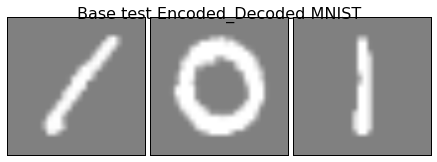

In [3]:
def next_batch(index,data,labels,batch_size=10):
    """Return the next `batch_size` examples from this data set."""
    total = data.shape[0]
    end = index + batch_size
    max_end =  max(0, index + batch_size - total)
    retData =  np.concatenate((data[index:end],data[:max_end]), axis=0)
    retlabel =  np.concatenate((labels[index:end],labels[:max_end]), axis=0)
    return retData,retlabel
def plot_gallery(title, images, n_col, n_row,image_shape = (28, 28)):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,            
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()   
    
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

# read training data from CSV file 
dataTrain = pd.read_csv('./kaggle-mnist/train.csv')
images = dataTrain.iloc[:,1:].values
images = images.astype(np.float)
images = np.multiply(images, 1.0 / 255.0)

labels_flat = dataTrain[[0]].values.ravel()
labels_count = np.unique(labels_flat).shape[0]
# labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels_flat #dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)
print(images.shape)
print(labels.shape)
for i in range(1):
    batch_xs, batch_ys = next_batch(i*10, images,labels)
    plot_gallery('Base test Encoded_Decoded MNIST',batch_xs[:3],3,1)



In [4]:
# # read test data from CSV file 
# datatest = pd.read_csv('./kaggle-mnist/test.csv')
# imagestest = datatest.iloc[:,:].values
# imagestest = imagestest.astype(np.float)
# imagestest = np.multiply(imagestest, 1.0 / 255.0)


RBM - Pre treino
---------

In [5]:

flags = tf.app.flags
FLAGS = flags.FLAGS
#flags.DEFINE_string('data_dir', '/home/ajsss/data_deep/', 'Directory for storing data')


In [11]:
from rbm import RBM

keep_prob_value = 1
# First RBM
rbmobject1 = RBM(784, 1000, ['rbmw1', 'rbvb1', 'rbmhb1'],0.3,keep_prob=keep_prob_value)
# Train First RBM
# with tf.device("/job:RBMAJSS/task:0/cpu:0"):
epoch = 50
batch_size =30
interactions = int(math.floor(images.shape[0]/batch_size))
for i in tqdm(range(epoch)):
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        cost = rbmobject1.partial_fit(batch_xs)
    print(rbmobject1.compute_cost(images))
rbmobject1.save_weights('./rbmw1.chp')
# Second RBM
rbmobject2 = RBM(1000, 500, ['rbmw2', 'rbvb2', 'rbmhb2'], 0.3,keep_prob=keep_prob_value)
# Train Second RBM
for i in tqdm(range(epoch)):
    for j in range(interactions):
        # Transform features with first rbm for second rbm
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        batch_xs = rbmobject1.transform(batch_xs)
        cost = rbmobject2.partial_fit(batch_xs)
    print(rbmobject2.compute_cost(rbmobject1.transform(images)))

rbmobject2.save_weights('./rbmw2.chp')
# third RBM
rbmobject3 = RBM(500, 250, ['rbmw3', 'rbvb3', 'rbmhb3'], 0.3,keep_prob=keep_prob_value)
# Train third RBM
for i in tqdm(range(epoch)):
    for j in range(interactions):
        # Transform features with first rbm for second rbm
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        batch_xs = rbmobject1.transform(batch_xs)
        batch_xs = rbmobject2.transform(batch_xs)
        cost = rbmobject3.partial_fit(batch_xs)
    print(rbmobject3.compute_cost(rbmobject2.transform(rbmobject1.transform(images))))

rbmobject3.save_weights('./rbmw3.chp')
# 4th RBM
rbmobject4 = RBM(250, 2, ['rbmw4', 'rbvb4', 'rbmhb4'], 0.3,keep_prob=keep_prob_value)
# Train 4th RBM
for i in tqdm(range(epoch)):
    for j in range(interactions):
        # Transform features with first rbm for second rbm
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        batch_xs = rbmobject1.transform(batch_xs)
        batch_xs = rbmobject2.transform(batch_xs)
        batch_xs = rbmobject3.transform(batch_xs)
        cost = rbmobject4.partial_fit(batch_xs)
    print(rbmobject4.compute_cost(rbmobject3.transform(rbmobject2.transform(rbmobject1.transform(images)))))

rbmobject4.save_weights('./rbmw4.chp')


  2%|▏         | 1/50 [00:12<10:04, 12.34s/it]

0.00781194


  4%|▍         | 2/50 [00:24<09:50, 12.31s/it]

0.00712113


  6%|▌         | 3/50 [00:36<09:37, 12.29s/it]

0.00681562


  8%|▊         | 4/50 [00:49<09:24, 12.28s/it]

0.0066006


 10%|█         | 5/50 [01:01<09:12, 12.27s/it]

0.00636947


 12%|█▏        | 6/50 [01:13<08:59, 12.27s/it]

0.00618691


 14%|█▍        | 7/50 [01:25<08:47, 12.26s/it]

0.00616454


 16%|█▌        | 8/50 [01:38<08:35, 12.26s/it]

0.00607781


 18%|█▊        | 9/50 [01:50<08:22, 12.25s/it]

0.00606399


 20%|██        | 10/50 [02:02<08:10, 12.25s/it]

0.00592966


 22%|██▏       | 11/50 [02:14<07:57, 12.25s/it]

0.00594645


 24%|██▍       | 12/50 [02:27<07:45, 12.25s/it]

0.00588751


 26%|██▌       | 13/50 [02:39<07:33, 12.25s/it]

0.0058901


 28%|██▊       | 14/50 [02:51<07:21, 12.25s/it]

0.00585365


 30%|███       | 15/50 [03:03<07:08, 12.25s/it]

0.00581987


 32%|███▏      | 16/50 [03:16<06:56, 12.25s/it]

0.00568216


 34%|███▍      | 17/50 [03:28<06:44, 12.25s/it]

0.00569118


 36%|███▌      | 18/50 [03:40<06:32, 12.25s/it]

0.00574734


 38%|███▊      | 19/50 [03:52<06:19, 12.26s/it]

0.00575465


 40%|████      | 20/50 [04:05<06:07, 12.25s/it]

0.00578176


 42%|████▏     | 21/50 [04:17<05:55, 12.25s/it]

0.00560285


 44%|████▍     | 22/50 [04:29<05:42, 12.25s/it]

0.00556477


 46%|████▌     | 23/50 [04:41<05:30, 12.25s/it]

0.00564949


 48%|████▊     | 24/50 [04:54<05:18, 12.25s/it]

0.00578601


 50%|█████     | 25/50 [05:06<05:06, 12.25s/it]

0.00571767


 52%|█████▏    | 26/50 [05:18<04:54, 12.25s/it]

0.0057024


 54%|█████▍    | 27/50 [05:30<04:41, 12.25s/it]

0.00553723


 56%|█████▌    | 28/50 [05:43<04:29, 12.24s/it]

0.0055742


 58%|█████▊    | 29/50 [05:55<04:16, 12.23s/it]

0.0056012


 60%|██████    | 30/50 [06:07<04:04, 12.23s/it]

0.00559076


 62%|██████▏   | 31/50 [06:19<03:52, 12.23s/it]

0.00556923


 64%|██████▍   | 32/50 [06:31<03:40, 12.24s/it]

0.00557315


 66%|██████▌   | 33/50 [06:44<03:27, 12.23s/it]

0.00551526


 68%|██████▊   | 34/50 [06:56<03:15, 12.23s/it]

0.00567413


 70%|███████   | 35/50 [07:08<03:03, 12.22s/it]

0.00546134


 72%|███████▏  | 36/50 [07:20<02:51, 12.22s/it]

0.00551523


 74%|███████▍  | 37/50 [07:33<02:38, 12.22s/it]

0.00550628


 76%|███████▌  | 38/50 [07:45<02:26, 12.22s/it]

0.00555866


 78%|███████▊  | 39/50 [07:57<02:14, 12.22s/it]

0.00572184


 80%|████████  | 40/50 [08:09<02:02, 12.20s/it]

0.00553218


 82%|████████▏ | 41/50 [08:21<01:49, 12.20s/it]

0.0055939


 84%|████████▍ | 42/50 [08:33<01:37, 12.19s/it]

0.00544039


 86%|████████▌ | 43/50 [08:46<01:25, 12.20s/it]

0.00561078


 88%|████████▊ | 44/50 [08:58<01:13, 12.20s/it]

0.00554616


 90%|█████████ | 45/50 [09:10<01:00, 12.19s/it]

0.00556916


 92%|█████████▏| 46/50 [09:22<00:48, 12.19s/it]

0.00547345


 94%|█████████▍| 47/50 [09:34<00:36, 12.18s/it]

0.00556895


 96%|█████████▌| 48/50 [09:47<00:24, 12.18s/it]

0.0054946


 98%|█████████▊| 49/50 [09:59<00:12, 12.18s/it]

0.00550211


100%|██████████| 50/50 [10:11<00:00, 12.20s/it]

0.00554469



  2%|▏         | 1/50 [00:13<11:11, 13.70s/it]

0.00688024


  4%|▍         | 2/50 [00:27<10:55, 13.66s/it]

0.00554261


  6%|▌         | 3/50 [00:40<10:40, 13.64s/it]

0.00506568


  8%|▊         | 4/50 [00:54<10:26, 13.62s/it]

0.00451873


 10%|█         | 5/50 [01:07<10:12, 13.61s/it]

0.00426532


 12%|█▏        | 6/50 [01:21<09:58, 13.60s/it]

0.00411103


 14%|█▍        | 7/50 [01:35<09:44, 13.59s/it]

0.00387135


 16%|█▌        | 8/50 [01:48<09:31, 13.60s/it]

0.0036999


 18%|█▊        | 9/50 [02:02<09:17, 13.60s/it]

0.0036214


 20%|██        | 10/50 [02:15<09:03, 13.59s/it]

0.00348728


 22%|██▏       | 11/50 [02:29<08:50, 13.60s/it]

0.00341546


 24%|██▍       | 12/50 [02:43<08:36, 13.60s/it]

0.00322922


 26%|██▌       | 13/50 [02:56<08:23, 13.60s/it]

0.00330967


 28%|██▊       | 14/50 [03:10<08:09, 13.60s/it]

0.00326497


 30%|███       | 15/50 [03:23<07:56, 13.60s/it]

0.00314455


 32%|███▏      | 16/50 [03:37<07:42, 13.60s/it]

0.00307617


 34%|███▍      | 17/50 [03:51<07:28, 13.60s/it]

0.00307828


 36%|███▌      | 18/50 [04:04<07:14, 13.59s/it]

0.00294001


 38%|███▊      | 19/50 [04:18<07:01, 13.60s/it]

0.00280478


 40%|████      | 20/50 [04:31<06:47, 13.60s/it]

0.00279399


 42%|████▏     | 21/50 [04:45<06:34, 13.59s/it]

0.0027902


 44%|████▍     | 22/50 [04:59<06:20, 13.60s/it]

0.00279704


 46%|████▌     | 23/50 [05:12<06:07, 13.60s/it]

0.00282936


 48%|████▊     | 24/50 [05:26<05:53, 13.59s/it]

0.00272337


 50%|█████     | 25/50 [05:39<05:39, 13.59s/it]

0.00272262


 52%|█████▏    | 26/50 [05:53<05:26, 13.60s/it]

0.00268288


 54%|█████▍    | 27/50 [06:07<05:12, 13.59s/it]

0.00268132


 56%|█████▌    | 28/50 [06:20<04:59, 13.59s/it]

0.00264788


 58%|█████▊    | 29/50 [06:34<04:45, 13.59s/it]

0.00260856


 60%|██████    | 30/50 [06:47<04:31, 13.59s/it]

0.00267596


 62%|██████▏   | 31/50 [07:01<04:18, 13.60s/it]

0.00258749


 64%|██████▍   | 32/50 [07:15<04:04, 13.58s/it]

0.0025205


 66%|██████▌   | 33/50 [07:28<03:50, 13.57s/it]

0.0025275


 68%|██████▊   | 34/50 [07:42<03:37, 13.58s/it]

0.00260737


 70%|███████   | 35/50 [07:55<03:23, 13.58s/it]

0.00256387


 72%|███████▏  | 36/50 [08:09<03:09, 13.56s/it]

0.00257624


 74%|███████▍  | 37/50 [08:22<02:56, 13.57s/it]

0.00243311


 76%|███████▌  | 38/50 [08:36<02:42, 13.55s/it]

0.00248927


 78%|███████▊  | 39/50 [08:49<02:29, 13.55s/it]

0.00247985


 80%|████████  | 40/50 [09:03<02:15, 13.56s/it]

0.00249823


 82%|████████▏ | 41/50 [09:17<02:02, 13.56s/it]

0.00253407


 84%|████████▍ | 42/50 [09:30<01:48, 13.55s/it]

0.00251875


 86%|████████▌ | 43/50 [09:44<01:34, 13.56s/it]

0.00246838


 88%|████████▊ | 44/50 [09:57<01:21, 13.56s/it]

0.00239388


 90%|█████████ | 45/50 [10:11<01:07, 13.55s/it]

0.00248104


 92%|█████████▏| 46/50 [10:24<00:54, 13.55s/it]

0.00245875


 94%|█████████▍| 47/50 [10:38<00:40, 13.55s/it]

0.00245882


 96%|█████████▌| 48/50 [10:51<00:27, 13.55s/it]

0.00256319


 98%|█████████▊| 49/50 [11:05<00:13, 13.55s/it]

0.00246413


100%|██████████| 50/50 [11:19<00:00, 13.56s/it]

0.00242423



  2%|▏         | 1/50 [00:12<10:35, 12.97s/it]

0.0056765


  4%|▍         | 2/50 [00:25<10:21, 12.95s/it]

0.00459754


  6%|▌         | 3/50 [00:38<10:07, 12.93s/it]

0.00402511


  8%|▊         | 4/50 [00:51<09:54, 12.92s/it]

0.00403605


 10%|█         | 5/50 [01:04<09:41, 12.92s/it]

0.00384375


 12%|█▏        | 6/50 [01:17<09:28, 12.92s/it]

0.00377498


 14%|█▍        | 7/50 [01:30<09:15, 12.92s/it]

0.00372393


 16%|█▌        | 8/50 [01:43<09:02, 12.91s/it]

0.00356962


 18%|█▊        | 9/50 [01:56<08:49, 12.91s/it]

0.00360157


 20%|██        | 10/50 [02:09<08:35, 12.90s/it]

0.00367427


 22%|██▏       | 11/50 [02:21<08:22, 12.89s/it]

0.00365439


 24%|██▍       | 12/50 [02:34<08:09, 12.89s/it]

0.00346912


 26%|██▌       | 13/50 [02:47<07:57, 12.90s/it]

0.00352938


 28%|██▊       | 14/50 [03:00<07:44, 12.90s/it]

0.00359073


 30%|███       | 15/50 [03:13<07:31, 12.90s/it]

0.00350757


 32%|███▏      | 16/50 [03:26<07:18, 12.91s/it]

0.00342771


 34%|███▍      | 17/50 [03:39<07:06, 12.91s/it]

0.00359419


 36%|███▌      | 18/50 [03:52<06:53, 12.93s/it]

0.00353759


 38%|███▊      | 19/50 [04:05<06:40, 12.93s/it]

0.00357319


 40%|████      | 20/50 [04:18<06:27, 12.93s/it]

0.00362516


 42%|████▏     | 21/50 [04:31<06:14, 12.93s/it]

0.00332504


 44%|████▍     | 22/50 [04:44<06:01, 12.92s/it]

0.003462


 46%|████▌     | 23/50 [04:56<05:48, 12.93s/it]

0.00333864


 48%|████▊     | 24/50 [05:09<05:36, 12.92s/it]

0.003293


 50%|█████     | 25/50 [05:22<05:23, 12.92s/it]

0.00344725


 52%|█████▏    | 26/50 [05:35<05:09, 12.90s/it]

0.00334967


 54%|█████▍    | 27/50 [05:48<04:56, 12.91s/it]

0.00324308


 56%|█████▌    | 28/50 [06:01<04:43, 12.90s/it]

0.00344175


 58%|█████▊    | 29/50 [06:14<04:31, 12.91s/it]

0.00323288


 60%|██████    | 30/50 [06:27<04:18, 12.92s/it]

0.00336596


 62%|██████▏   | 31/50 [06:40<04:05, 12.92s/it]

0.00317875


 64%|██████▍   | 32/50 [06:53<03:52, 12.92s/it]

0.00332472


 66%|██████▌   | 33/50 [07:06<03:39, 12.91s/it]

0.00319951


 68%|██████▊   | 34/50 [07:19<03:26, 12.91s/it]

0.00326414


 70%|███████   | 35/50 [07:31<03:13, 12.91s/it]

0.00323904


 72%|███████▏  | 36/50 [07:44<03:00, 12.91s/it]

0.00322566


 74%|███████▍  | 37/50 [07:57<02:48, 12.92s/it]

0.00340266


 76%|███████▌  | 38/50 [08:10<02:34, 12.91s/it]

0.00332822


 78%|███████▊  | 39/50 [08:23<02:22, 12.91s/it]

0.00328229


 80%|████████  | 40/50 [08:36<02:09, 12.92s/it]

0.00311801


 82%|████████▏ | 41/50 [08:49<01:56, 12.93s/it]

0.00327564


 84%|████████▍ | 42/50 [09:02<01:43, 12.91s/it]

0.00318558


 86%|████████▌ | 43/50 [09:15<01:30, 12.92s/it]

0.00320896


 88%|████████▊ | 44/50 [09:28<01:17, 12.91s/it]

0.00323423


 90%|█████████ | 45/50 [09:41<01:04, 12.91s/it]

0.00331415


 92%|█████████▏| 46/50 [09:54<00:51, 12.92s/it]

0.00321683


 94%|█████████▍| 47/50 [10:06<00:38, 12.92s/it]

0.00329505


 96%|█████████▌| 48/50 [10:19<00:25, 12.92s/it]

0.00325422


 98%|█████████▊| 49/50 [10:32<00:12, 12.93s/it]

0.00328203


100%|██████████| 50/50 [10:45<00:00, 12.92s/it]

0.00327823



  2%|▏         | 1/50 [00:13<10:52, 13.32s/it]

0.0986317


  4%|▍         | 2/50 [00:26<10:34, 13.22s/it]

0.0986316


  6%|▌         | 3/50 [00:39<10:18, 13.15s/it]

0.0986316


  8%|▊         | 4/50 [00:52<10:03, 13.11s/it]

0.0986316


 10%|█         | 5/50 [01:05<09:48, 13.08s/it]

0.0986316


 12%|█▏        | 6/50 [01:18<09:33, 13.04s/it]

0.0986316


 14%|█▍        | 7/50 [01:31<09:20, 13.04s/it]

0.0986316


 16%|█▌        | 8/50 [01:44<09:07, 13.02s/it]

0.0986316


 18%|█▊        | 9/50 [01:57<08:53, 13.01s/it]

0.0986316


 20%|██        | 10/50 [02:10<08:40, 13.02s/it]

0.0986316


 22%|██▏       | 11/50 [02:23<08:27, 13.01s/it]

0.0986316


 24%|██▍       | 12/50 [02:36<08:14, 13.01s/it]

0.0986316


 26%|██▌       | 13/50 [02:49<08:02, 13.03s/it]

0.0986316


 28%|██▊       | 14/50 [03:02<07:48, 13.01s/it]

0.0986316


 30%|███       | 15/50 [03:15<07:35, 13.02s/it]

0.0986316


 32%|███▏      | 16/50 [03:28<07:23, 13.03s/it]

0.0986316


 34%|███▍      | 17/50 [03:41<07:09, 13.02s/it]

0.0986316


 36%|███▌      | 18/50 [03:54<06:56, 13.01s/it]

0.0986316


 38%|███▊      | 19/50 [04:07<06:43, 13.01s/it]

0.0986313


 40%|████      | 20/50 [04:20<06:29, 12.99s/it]

0.0986316


 42%|████▏     | 21/50 [04:33<06:16, 12.99s/it]

0.0986316


 44%|████▍     | 22/50 [04:46<06:03, 12.99s/it]

0.0986316


 46%|████▌     | 23/50 [04:59<05:49, 12.96s/it]

0.0986316


 48%|████▊     | 24/50 [05:12<05:37, 12.98s/it]

0.0986316


 50%|█████     | 25/50 [05:25<05:24, 12.99s/it]

0.0986316


 52%|█████▏    | 26/50 [05:38<05:11, 13.00s/it]

0.0986316


 54%|█████▍    | 27/50 [05:51<04:58, 13.00s/it]

0.0986316


 56%|█████▌    | 28/50 [06:04<04:45, 12.98s/it]

0.0986316


 58%|█████▊    | 29/50 [06:17<04:32, 13.00s/it]

0.0986316


 60%|██████    | 30/50 [06:30<04:19, 13.00s/it]

0.0986316


 62%|██████▏   | 31/50 [06:43<04:07, 13.00s/it]

0.0986316


 64%|██████▍   | 32/50 [06:56<03:54, 13.01s/it]

0.0986316


 66%|██████▌   | 33/50 [07:09<03:40, 12.99s/it]

0.0986316


 68%|██████▊   | 34/50 [07:22<03:27, 13.00s/it]

0.0986316


 70%|███████   | 35/50 [07:35<03:14, 12.99s/it]

0.0986316


 72%|███████▏  | 36/50 [07:48<03:01, 12.99s/it]

0.0986316


 74%|███████▍  | 37/50 [08:01<02:48, 13.00s/it]

0.0986316


 76%|███████▌  | 38/50 [08:14<02:35, 13.00s/it]

0.0986316


 78%|███████▊  | 39/50 [08:27<02:22, 13.00s/it]

0.0986316


 80%|████████  | 40/50 [08:40<02:10, 13.00s/it]

0.0986316


 82%|████████▏ | 41/50 [08:53<01:56, 13.00s/it]

0.0986316


 84%|████████▍ | 42/50 [09:06<01:44, 13.00s/it]

0.0986316


 86%|████████▌ | 43/50 [09:19<01:31, 13.00s/it]

0.0986316


 88%|████████▊ | 44/50 [09:32<01:17, 13.00s/it]

0.0986316


 90%|█████████ | 45/50 [09:45<01:04, 12.99s/it]

0.0986316


 92%|█████████▏| 46/50 [09:58<00:51, 12.99s/it]

0.0986316


 94%|█████████▍| 47/50 [10:11<00:38, 12.98s/it]

0.0986316


 96%|█████████▌| 48/50 [10:24<00:25, 12.99s/it]

0.0986316


 98%|█████████▊| 49/50 [10:37<00:12, 12.99s/it]

0.0986316


100%|██████████| 50/50 [10:50<00:00, 12.99s/it]

0.0986316


WITHOUT DROPOUT relu in enc layers and sigmoid on dec layers
-------

In [6]:
from au import AutoEncoder

# Train Autoencoder
batch_size =30
epoch = 100
keep_prob_value = 1
# Autoencoder
autoencoder = AutoEncoder(784, [1000, 500,250,2],  [['rbmw1', 'rbmhb1'],
                                                ['rbmw2', 'rbmhb2'],
                                                ['rbmw3', 'rbmhb3'],
                                                   ['rbmw4', 'rbmhb4']],
                                           tied_weights=False,keep_prob=keep_prob_value)
# Load RBM weights to Autoencoder
autoencoder.load_rbm_weights('./rbmw1.chp', ['rbmw1', 'rbmhb1'], 0)
autoencoder.load_rbm_weights('./rbmw2.chp', ['rbmw2', 'rbmhb2'], 1)
autoencoder.load_rbm_weights('./rbmw3.chp', ['rbmw3', 'rbmhb3'], 2)
autoencoder.load_rbm_weights('./rbmw4.chp', ['rbmw4', 'rbmhb4'], 3)

interactions = int(math.floor(images.shape[0]/batch_size))
print('autoencoder')
for i in tqdm(range(epoch)):
    cost = 0.0
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        cost += autoencoder.partial_fit(batch_xs)
    print(i,'cost: ',cost)

autoencoder.save_weights('./au.chp')


  0%|          | 0/100 [00:00<?, ?it/s]

autoencoder


  1%|          | 1/100 [00:09<15:14,  9.23s/it]

0 cost:  367.405861393


  2%|▏         | 2/100 [00:18<15:02,  9.21s/it]

1 cost:  363.987598479


  3%|▎         | 3/100 [00:27<14:50,  9.18s/it]

2 cost:  363.91648069


  4%|▍         | 4/100 [00:36<14:40,  9.17s/it]

3 cost:  365.218934059


  5%|▌         | 5/100 [00:45<14:28,  9.14s/it]

4 cost:  350.381838337


  6%|▌         | 6/100 [00:54<14:14,  9.09s/it]

5 cost:  343.03377828


  7%|▋         | 7/100 [01:03<14:01,  9.05s/it]

6 cost:  335.498305395


  8%|▊         | 8/100 [01:12<13:53,  9.06s/it]

7 cost:  333.342093512


  9%|▉         | 9/100 [01:21<13:45,  9.07s/it]

8 cost:  334.704280466


 10%|█         | 10/100 [01:30<13:36,  9.07s/it]

9 cost:  332.067875281


 11%|█         | 11/100 [01:39<13:27,  9.07s/it]

10 cost:  331.670576155


 12%|█▏        | 12/100 [01:49<13:18,  9.08s/it]

11 cost:  331.605970711


 13%|█▎        | 13/100 [01:58<13:10,  9.08s/it]

12 cost:  328.324086234


 14%|█▍        | 14/100 [02:07<13:01,  9.08s/it]

13 cost:  330.323285416


 15%|█▌        | 15/100 [02:16<12:52,  9.09s/it]

14 cost:  327.683536261


 16%|█▌        | 16/100 [02:25<12:43,  9.09s/it]

15 cost:  325.585152432


 17%|█▋        | 17/100 [02:34<12:34,  9.10s/it]

16 cost:  326.669927791


 18%|█▊        | 18/100 [02:43<12:26,  9.10s/it]

17 cost:  324.728267461


 19%|█▉        | 19/100 [02:52<12:17,  9.10s/it]

18 cost:  326.252366096


 20%|██        | 20/100 [03:01<12:08,  9.11s/it]

19 cost:  323.860697538


 21%|██        | 21/100 [03:11<11:59,  9.11s/it]

20 cost:  326.193315879


 22%|██▏       | 22/100 [03:20<11:50,  9.11s/it]

21 cost:  323.29088743


 23%|██▎       | 23/100 [03:29<11:41,  9.11s/it]

22 cost:  322.749249801


 24%|██▍       | 24/100 [03:38<11:32,  9.12s/it]

23 cost:  322.290266663


 25%|██▌       | 25/100 [03:47<11:23,  9.12s/it]

24 cost:  319.829199985


 26%|██▌       | 26/100 [03:56<11:14,  9.11s/it]

25 cost:  318.583046108


 27%|██▋       | 27/100 [04:05<11:05,  9.11s/it]

26 cost:  320.576985016


 28%|██▊       | 28/100 [04:14<10:55,  9.11s/it]

27 cost:  319.44882527


 29%|██▉       | 29/100 [04:23<10:46,  9.10s/it]

28 cost:  319.100323856


 30%|███       | 30/100 [04:32<10:37,  9.11s/it]

29 cost:  319.709779516


 31%|███       | 31/100 [04:42<10:28,  9.10s/it]

30 cost:  319.879393309


 32%|███▏      | 32/100 [04:51<10:18,  9.10s/it]

31 cost:  319.73250632


 33%|███▎      | 33/100 [05:00<10:09,  9.10s/it]

32 cost:  321.006693944


 34%|███▍      | 34/100 [05:09<10:00,  9.11s/it]

33 cost:  320.258498862


 35%|███▌      | 35/100 [05:18<09:51,  9.11s/it]

34 cost:  323.719582558


 36%|███▌      | 36/100 [05:27<09:42,  9.11s/it]

35 cost:  321.449093953


 37%|███▋      | 37/100 [05:36<09:34,  9.12s/it]

36 cost:  321.742915824


 38%|███▊      | 38/100 [05:45<09:25,  9.12s/it]

37 cost:  318.074817538


 39%|███▉      | 39/100 [05:55<09:16,  9.12s/it]

38 cost:  317.866348729


 40%|████      | 40/100 [06:04<09:07,  9.12s/it]

39 cost:  322.56796658


 41%|████      | 41/100 [06:13<08:58,  9.12s/it]

40 cost:  320.464135557


 42%|████▏     | 42/100 [06:22<08:49,  9.12s/it]

41 cost:  317.445736513


 43%|████▎     | 43/100 [06:31<08:39,  9.12s/it]

42 cost:  316.863541543


 44%|████▍     | 44/100 [06:40<08:30,  9.12s/it]

43 cost:  316.836939782


 45%|████▌     | 45/100 [06:49<08:20,  9.10s/it]

44 cost:  315.754785925


 46%|████▌     | 46/100 [06:58<08:11,  9.10s/it]

45 cost:  318.360253289


 47%|████▋     | 47/100 [07:07<08:01,  9.09s/it]

46 cost:  316.395390227


 48%|████▊     | 48/100 [07:16<07:52,  9.08s/it]

47 cost:  318.695858702


 49%|████▉     | 49/100 [07:25<07:43,  9.08s/it]

48 cost:  320.704532281


 50%|█████     | 50/100 [07:35<07:33,  9.07s/it]

49 cost:  319.047722057


 51%|█████     | 51/100 [07:44<07:24,  9.07s/it]

50 cost:  317.628400102


 52%|█████▏    | 52/100 [07:53<07:15,  9.07s/it]

51 cost:  317.651934221


 53%|█████▎    | 53/100 [08:02<07:06,  9.07s/it]

52 cost:  317.072900593


 54%|█████▍    | 54/100 [08:11<06:57,  9.07s/it]

53 cost:  317.310011283


 55%|█████▌    | 55/100 [08:20<06:48,  9.07s/it]

54 cost:  318.454322383


 56%|█████▌    | 56/100 [08:29<06:38,  9.07s/it]

55 cost:  315.811572194


 57%|█████▋    | 57/100 [08:38<06:29,  9.06s/it]

56 cost:  317.381238535


 58%|█████▊    | 58/100 [08:47<06:20,  9.07s/it]

57 cost:  315.501568139


 59%|█████▉    | 59/100 [08:56<06:11,  9.07s/it]

58 cost:  320.470610768


 60%|██████    | 60/100 [09:05<06:03,  9.08s/it]

59 cost:  323.98705256


 61%|██████    | 61/100 [09:14<05:54,  9.09s/it]

60 cost:  323.665076613


 62%|██████▏   | 62/100 [09:23<05:45,  9.09s/it]

61 cost:  322.861676276


 63%|██████▎   | 63/100 [09:32<05:36,  9.09s/it]

62 cost:  320.504665866


 64%|██████▍   | 64/100 [09:42<05:27,  9.08s/it]

63 cost:  321.689029112


 65%|██████▌   | 65/100 [09:51<05:17,  9.08s/it]

64 cost:  319.520527273


 66%|██████▌   | 66/100 [10:00<05:08,  9.09s/it]

65 cost:  317.547840789


 67%|██████▋   | 67/100 [10:09<04:59,  9.08s/it]

66 cost:  317.819175899


 68%|██████▊   | 68/100 [10:18<04:50,  9.08s/it]

67 cost:  320.142888293


 69%|██████▉   | 69/100 [10:27<04:41,  9.08s/it]

68 cost:  317.214477003


 70%|███████   | 70/100 [10:36<04:32,  9.08s/it]

69 cost:  318.958598316


 71%|███████   | 71/100 [10:45<04:23,  9.08s/it]

70 cost:  318.865326732


 72%|███████▏  | 72/100 [10:54<04:14,  9.08s/it]

71 cost:  322.497984394


 73%|███████▎  | 73/100 [11:03<04:05,  9.08s/it]

72 cost:  321.145511895


 74%|███████▍  | 74/100 [11:12<03:56,  9.08s/it]

73 cost:  318.749823779


 75%|███████▌  | 75/100 [11:21<03:46,  9.08s/it]

74 cost:  318.786261559


 76%|███████▌  | 76/100 [11:31<03:37,  9.08s/it]

75 cost:  317.204135001


 77%|███████▋  | 77/100 [11:40<03:28,  9.08s/it]

76 cost:  317.306250587


 78%|███████▊  | 78/100 [11:49<03:19,  9.08s/it]

77 cost:  319.507394984


 79%|███████▉  | 79/100 [11:58<03:10,  9.09s/it]

78 cost:  318.646053895


 80%|████████  | 80/100 [12:07<03:01,  9.09s/it]

79 cost:  320.390432134


 81%|████████  | 81/100 [12:16<02:52,  9.08s/it]

80 cost:  318.493328691


 82%|████████▏ | 82/100 [12:25<02:43,  9.08s/it]

81 cost:  316.795333967


 83%|████████▎ | 83/100 [12:34<02:34,  9.08s/it]

82 cost:  319.076902166


 84%|████████▍ | 84/100 [12:43<02:25,  9.08s/it]

83 cost:  316.831932053


 85%|████████▌ | 85/100 [12:52<02:16,  9.08s/it]

84 cost:  315.103571489


 86%|████████▌ | 86/100 [13:01<02:07,  9.08s/it]

85 cost:  315.576907143


 87%|████████▋ | 87/100 [13:10<01:58,  9.08s/it]

86 cost:  316.081775144


 88%|████████▊ | 88/100 [13:20<01:48,  9.08s/it]

87 cost:  314.718772471


 89%|████████▉ | 89/100 [13:29<01:39,  9.09s/it]

88 cost:  316.93403776


 90%|█████████ | 90/100 [13:38<01:30,  9.08s/it]

89 cost:  316.591956794


 91%|█████████ | 91/100 [13:47<01:21,  9.08s/it]

90 cost:  316.271161586


 92%|█████████▏| 92/100 [13:56<01:12,  9.08s/it]

91 cost:  315.533364296


 93%|█████████▎| 93/100 [14:05<01:03,  9.08s/it]

92 cost:  315.782489553


 94%|█████████▍| 94/100 [14:14<00:54,  9.08s/it]

93 cost:  316.434661806


 95%|█████████▌| 95/100 [14:23<00:45,  9.08s/it]

94 cost:  317.420593664


 96%|█████████▌| 96/100 [14:32<00:36,  9.09s/it]

95 cost:  318.547203496


 97%|█████████▋| 97/100 [14:41<00:27,  9.08s/it]

96 cost:  325.188046634


 98%|█████████▊| 98/100 [14:50<00:18,  9.08s/it]

97 cost:  325.328415692


 99%|█████████▉| 99/100 [14:59<00:09,  9.08s/it]

98 cost:  320.180971757


100%|██████████| 100/100 [15:08<00:00,  9.08s/it]

99 cost:  316.607984066


[[ 124948.5078125    52605.27734375]
 [ 174743.           15743.92871094]
 [ 310236.46875     269808.625     ]
 ..., 
 [ 240574.96875      79211.34375   ]
 [   9677.05761719   21976.09570312]
 [  13523.97460938   23328.51171875]]


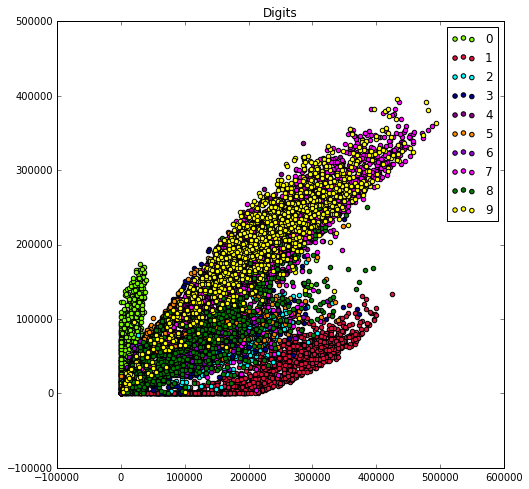

In [7]:
from sklearn.cross_validation import train_test_split
autoencoder.load_weights('./au.chp')
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = autoencoder.transform(X_test)
print(X_transformed)
colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")


WITH DROPOUT sigmoid in enc layers and sigmoid on dec layers
-------

In [8]:
from au import AutoEncoder

# Train Autoencoder
batch_size =30
epoch = 100
keep_prob_value = 0.9
# Autoencoder
autoencoder = AutoEncoder(784, [1000, 500,250,2],  [['rbmw1', 'rbmhb1'],
                                                ['rbmw2', 'rbmhb2'],
                                                ['rbmw3', 'rbmhb3'],
                                                   ['rbmw4', 'rbmhb4']],
                                           tied_weights=False,keep_prob=keep_prob_value,
                                          transfer_function_enc=tf.nn.sigmoid,
                                          transfer_function_dec=tf.nn.sigmoid)
# Load RBM weights to Autoencoder
autoencoder.load_rbm_weights('./rbmw1.chp', ['rbmw1', 'rbmhb1'], 0)
autoencoder.load_rbm_weights('./rbmw2.chp', ['rbmw2', 'rbmhb2'], 1)
autoencoder.load_rbm_weights('./rbmw3.chp', ['rbmw3', 'rbmhb3'], 2)
autoencoder.load_rbm_weights('./rbmw4.chp', ['rbmw4', 'rbmhb4'], 3)

interactions = int(math.floor(images.shape[0]/batch_size))
print('autoencoder')
for i in tqdm(range(epoch)):
    cost = 0.0
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        cost += autoencoder.partial_fit(batch_xs)
    print(i,'cost: ',cost)

autoencoder.save_weights('./au2.chp')


  0%|          | 0/100 [00:00<?, ?it/s]

autoencoder


  1%|          | 1/100 [00:08<14:42,  8.91s/it]

0 cost:  378.416933417


  2%|▏         | 2/100 [00:17<14:30,  8.89s/it]

1 cost:  362.298144996


  3%|▎         | 3/100 [00:26<14:18,  8.85s/it]

2 cost:  358.616367042


  4%|▍         | 4/100 [00:35<14:08,  8.84s/it]

3 cost:  354.393919691


  5%|▌         | 5/100 [00:44<13:59,  8.84s/it]

4 cost:  350.005772457


  6%|▌         | 6/100 [00:52<13:49,  8.83s/it]

5 cost:  347.642078593


  7%|▋         | 7/100 [01:01<13:40,  8.82s/it]

6 cost:  345.336522385


  8%|▊         | 8/100 [01:10<13:30,  8.81s/it]

7 cost:  342.408490732


  9%|▉         | 9/100 [01:19<13:22,  8.82s/it]

8 cost:  339.178932652


 10%|█         | 10/100 [01:28<13:13,  8.82s/it]

9 cost:  335.920595869


 11%|█         | 11/100 [01:37<13:04,  8.82s/it]

10 cost:  333.758481577


 12%|█▏        | 12/100 [01:45<12:56,  8.82s/it]

11 cost:  331.062044203


 13%|█▎        | 13/100 [01:54<12:46,  8.81s/it]

12 cost:  328.75381504


 14%|█▍        | 14/100 [02:03<12:37,  8.81s/it]

13 cost:  327.483027861


 15%|█▌        | 15/100 [02:12<12:28,  8.81s/it]

14 cost:  325.431656092


 16%|█▌        | 16/100 [02:21<12:20,  8.81s/it]

15 cost:  324.358620316


 17%|█▋        | 17/100 [02:29<12:11,  8.81s/it]

16 cost:  322.533083826


 18%|█▊        | 18/100 [02:38<12:02,  8.81s/it]

17 cost:  321.833457693


 19%|█▉        | 19/100 [02:47<11:53,  8.81s/it]

18 cost:  320.587804303


 20%|██        | 20/100 [02:56<11:44,  8.81s/it]

19 cost:  319.710861281


 21%|██        | 21/100 [03:05<11:35,  8.81s/it]

20 cost:  319.216824785


 22%|██▏       | 22/100 [03:13<11:27,  8.81s/it]

21 cost:  318.359403029


 23%|██▎       | 23/100 [03:22<11:18,  8.81s/it]

22 cost:  317.499673069


 24%|██▍       | 24/100 [03:31<11:07,  8.79s/it]

23 cost:  317.118969038


 25%|██▌       | 25/100 [03:40<10:58,  8.78s/it]

24 cost:  316.811302334


 26%|██▌       | 26/100 [03:49<10:50,  8.79s/it]

25 cost:  316.465532914


 27%|██▋       | 27/100 [03:57<10:42,  8.80s/it]

26 cost:  315.805859119


 28%|██▊       | 28/100 [04:06<10:33,  8.80s/it]

27 cost:  315.199503452


 29%|██▉       | 29/100 [04:15<10:25,  8.81s/it]

28 cost:  314.797222182


 30%|███       | 30/100 [04:24<10:17,  8.81s/it]

29 cost:  314.685470551


 31%|███       | 31/100 [04:33<10:08,  8.81s/it]

30 cost:  313.858718932


 32%|███▏      | 32/100 [04:41<09:59,  8.81s/it]

31 cost:  313.913987204


 33%|███▎      | 33/100 [04:50<09:50,  8.81s/it]

32 cost:  313.656977192


 34%|███▍      | 34/100 [04:59<09:41,  8.81s/it]

33 cost:  312.998322651


 35%|███▌      | 35/100 [05:08<09:32,  8.80s/it]

34 cost:  313.127259195


 36%|███▌      | 36/100 [05:17<09:22,  8.79s/it]

35 cost:  314.117196128


 37%|███▋      | 37/100 [05:25<09:14,  8.81s/it]

36 cost:  312.683452427


 38%|███▊      | 38/100 [05:34<09:06,  8.81s/it]

37 cost:  312.500459328


 39%|███▉      | 39/100 [05:43<08:58,  8.82s/it]

38 cost:  312.365426332


 40%|████      | 40/100 [05:52<08:49,  8.82s/it]

39 cost:  312.377101511


 41%|████      | 41/100 [06:01<08:40,  8.83s/it]

40 cost:  311.661177158


 42%|████▏     | 42/100 [06:10<08:32,  8.84s/it]

41 cost:  311.424947649


 43%|████▎     | 43/100 [06:18<08:23,  8.84s/it]

42 cost:  311.094643861


 44%|████▍     | 44/100 [06:27<08:14,  8.84s/it]

43 cost:  311.060208425


 45%|████▌     | 45/100 [06:36<08:06,  8.84s/it]

44 cost:  310.754002064


 46%|████▌     | 46/100 [06:45<07:57,  8.84s/it]

45 cost:  310.783707619


 47%|████▋     | 47/100 [06:54<07:48,  8.84s/it]

46 cost:  310.578550607


 48%|████▊     | 48/100 [07:03<07:39,  8.84s/it]

47 cost:  310.231317282


 49%|████▉     | 49/100 [07:12<07:30,  8.83s/it]

48 cost:  310.444506705


 50%|█████     | 50/100 [07:20<07:21,  8.83s/it]

49 cost:  310.292651013


 51%|█████     | 51/100 [07:29<07:13,  8.84s/it]

50 cost:  310.05337657


 52%|█████▏    | 52/100 [07:38<07:04,  8.84s/it]

51 cost:  309.7063642


 53%|█████▎    | 53/100 [07:47<06:55,  8.84s/it]

52 cost:  310.10427393


 54%|█████▍    | 54/100 [07:56<06:46,  8.83s/it]

53 cost:  309.745962277


 55%|█████▌    | 55/100 [08:05<06:37,  8.83s/it]

54 cost:  309.46015057


 56%|█████▌    | 56/100 [08:13<06:28,  8.84s/it]

55 cost:  309.646581531


 57%|█████▋    | 57/100 [08:22<06:19,  8.84s/it]

56 cost:  309.429581463


 58%|█████▊    | 58/100 [08:31<06:11,  8.84s/it]

57 cost:  309.181933075


 59%|█████▉    | 59/100 [08:40<06:02,  8.85s/it]

58 cost:  308.901208654


 60%|██████    | 60/100 [08:49<05:53,  8.85s/it]

59 cost:  308.825786501


 61%|██████    | 61/100 [08:58<05:45,  8.85s/it]

60 cost:  308.643092647


 62%|██████▏   | 62/100 [09:06<05:36,  8.85s/it]

61 cost:  308.596195683


 63%|██████▎   | 63/100 [09:15<05:27,  8.85s/it]

62 cost:  308.243454084


 64%|██████▍   | 64/100 [09:24<05:18,  8.85s/it]

63 cost:  308.034437254


 65%|██████▌   | 65/100 [09:33<05:09,  8.85s/it]

64 cost:  307.955917627


 66%|██████▌   | 66/100 [09:42<05:01,  8.86s/it]

65 cost:  307.933431163


 67%|██████▋   | 67/100 [09:51<04:52,  8.86s/it]

66 cost:  308.625901818


 68%|██████▊   | 68/100 [10:00<04:43,  8.86s/it]

67 cost:  308.723396689


 69%|██████▉   | 69/100 [10:08<04:34,  8.86s/it]

68 cost:  308.25676398


 70%|███████   | 70/100 [10:17<04:25,  8.86s/it]

69 cost:  308.023861036


 71%|███████   | 71/100 [10:26<04:16,  8.86s/it]

70 cost:  308.094645873


 72%|███████▏  | 72/100 [10:35<04:07,  8.85s/it]

71 cost:  307.993774444


 73%|███████▎  | 73/100 [10:44<03:59,  8.85s/it]

72 cost:  307.768812239


 74%|███████▍  | 74/100 [10:53<03:50,  8.85s/it]

73 cost:  307.606764331


 75%|███████▌  | 75/100 [11:02<03:41,  8.85s/it]

74 cost:  307.73573947


 76%|███████▌  | 76/100 [11:10<03:32,  8.85s/it]

75 cost:  307.606304958


 77%|███████▋  | 77/100 [11:19<03:23,  8.86s/it]

76 cost:  307.576891512


 78%|███████▊  | 78/100 [11:28<03:14,  8.86s/it]

77 cost:  307.258996785


 79%|███████▉  | 79/100 [11:37<03:05,  8.86s/it]

78 cost:  307.018309429


 80%|████████  | 80/100 [11:46<02:57,  8.85s/it]

79 cost:  307.412812039


 81%|████████  | 81/100 [11:55<02:48,  8.85s/it]

80 cost:  307.234689638


 82%|████████▏ | 82/100 [12:04<02:39,  8.85s/it]

81 cost:  306.834324434


 83%|████████▎ | 83/100 [12:12<02:30,  8.86s/it]

82 cost:  306.859245002


 84%|████████▍ | 84/100 [12:21<02:21,  8.86s/it]

83 cost:  306.863003328


 85%|████████▌ | 85/100 [12:30<02:12,  8.86s/it]

84 cost:  306.484118611


 86%|████████▌ | 86/100 [12:39<02:03,  8.86s/it]

85 cost:  306.804569155


 87%|████████▋ | 87/100 [12:48<01:55,  8.86s/it]

86 cost:  306.665024653


 88%|████████▊ | 88/100 [12:57<01:46,  8.86s/it]

87 cost:  306.570551753


 89%|████████▉ | 89/100 [13:06<01:37,  8.86s/it]

88 cost:  306.530932978


 90%|█████████ | 90/100 [13:14<01:28,  8.86s/it]

89 cost:  306.314760268


 91%|█████████ | 91/100 [13:23<01:19,  8.86s/it]

90 cost:  306.743198678


 92%|█████████▏| 92/100 [13:32<01:10,  8.86s/it]

91 cost:  306.753044888


 93%|█████████▎| 93/100 [13:41<01:01,  8.86s/it]

92 cost:  306.244060114


 94%|█████████▍| 94/100 [13:50<00:53,  8.86s/it]

93 cost:  306.167524517


 95%|█████████▌| 95/100 [13:59<00:44,  8.86s/it]

94 cost:  306.136830047


 96%|█████████▌| 96/100 [14:08<00:35,  8.86s/it]

95 cost:  305.99201189


 97%|█████████▋| 97/100 [14:16<00:26,  8.86s/it]

96 cost:  306.1969506


 98%|█████████▊| 98/100 [14:25<00:17,  8.86s/it]

97 cost:  306.445528328


 99%|█████████▉| 99/100 [14:34<00:08,  8.86s/it]

98 cost:  306.043703958


100%|██████████| 100/100 [14:43<00:00,  8.86s/it]

99 cost:  305.993445501


[[ 0.44935453  0.2332243 ]
 [ 0.0721437   0.11632926]
 [ 0.46362221  0.40116641]
 ..., 
 [ 0.23658885  0.12677786]
 [ 0.465626    0.67585903]
 [ 0.91257793  0.78890514]]


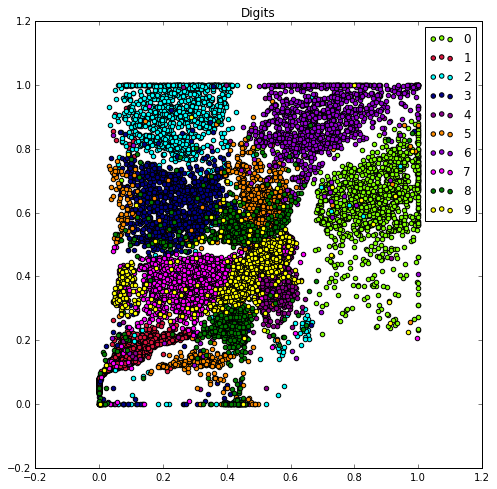

In [9]:
from sklearn.cross_validation import train_test_split
autoencoder.load_weights('./au2.chp')
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = autoencoder.transform(X_test)
print(X_transformed)
colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")


WITHOUT DROPOUT sigmoid in enc layers and sigmoid on dec layers
-------

In [14]:
from au import AutoEncoder

# Train Autoencoder
batch_size =30
epoch = 100
keep_prob_value = 1
# Autoencoder
autoencoder = AutoEncoder(784, [1000, 500,250,2],  [['rbmw1', 'rbmhb1'],
                                                ['rbmw2', 'rbmhb2'],
                                                ['rbmw3', 'rbmhb3'],
                                                   ['rbmw4', 'rbmhb4']],
                                           tied_weights=False,keep_prob=keep_prob_value,
                                          transfer_function_enc=tf.nn.sigmoid,
                                          transfer_function_dec=tf.nn.sigmoid)
# Load RBM weights to Autoencoder
autoencoder.load_rbm_weights('./rbmw1.chp', ['rbmw1', 'rbmhb1'], 0)
autoencoder.load_rbm_weights('./rbmw2.chp', ['rbmw2', 'rbmhb2'], 1)
autoencoder.load_rbm_weights('./rbmw3.chp', ['rbmw3', 'rbmhb3'], 2)
autoencoder.load_rbm_weights('./rbmw4.chp', ['rbmw4', 'rbmhb4'], 3)

interactions = int(math.floor(images.shape[0]/batch_size))
print('autoencoder')
for i in tqdm(range(epoch)):
    cost = 0.0
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        cost += autoencoder.partial_fit(batch_xs)
    print(i,'cost: ',cost)

autoencoder.save_weights('./au5.chp')


  0%|          | 0/100 [00:00<?, ?it/s]

autoencoder


  1%|          | 1/100 [00:08<14:47,  8.96s/it]

0 cost:  345.293216094


  2%|▏         | 2/100 [00:17<14:37,  8.95s/it]

1 cost:  327.862918034


  3%|▎         | 3/100 [00:26<14:27,  8.94s/it]

2 cost:  312.109177604


  4%|▍         | 4/100 [00:35<14:17,  8.93s/it]

3 cost:  298.904504731


  5%|▌         | 5/100 [00:44<14:08,  8.93s/it]

4 cost:  292.18130143


  6%|▌         | 6/100 [00:53<13:59,  8.93s/it]

5 cost:  287.645516425


  7%|▋         | 7/100 [01:02<13:50,  8.93s/it]

6 cost:  283.981396109


  8%|▊         | 8/100 [01:11<13:40,  8.92s/it]

7 cost:  280.981184557


  9%|▉         | 9/100 [01:20<13:31,  8.92s/it]

8 cost:  279.135220438


 10%|█         | 10/100 [01:29<13:22,  8.92s/it]

9 cost:  276.728059694


 11%|█         | 11/100 [01:38<13:13,  8.91s/it]

10 cost:  275.173724994


 12%|█▏        | 12/100 [01:47<13:04,  8.92s/it]

11 cost:  273.969566971


 13%|█▎        | 13/100 [01:56<12:56,  8.92s/it]

12 cost:  272.281751126


 14%|█▍        | 14/100 [02:04<12:46,  8.92s/it]

13 cost:  271.104245558


 15%|█▌        | 15/100 [02:13<12:37,  8.92s/it]

14 cost:  270.21358934


 16%|█▌        | 16/100 [02:22<12:29,  8.92s/it]

15 cost:  269.603205934


 17%|█▋        | 17/100 [02:31<12:20,  8.92s/it]

16 cost:  268.433497056


 18%|█▊        | 18/100 [02:40<12:11,  8.93s/it]

17 cost:  267.560814455


 19%|█▉        | 19/100 [02:49<12:02,  8.92s/it]

18 cost:  266.725834563


 20%|██        | 20/100 [02:58<11:54,  8.93s/it]

19 cost:  266.38118501


 21%|██        | 21/100 [03:07<11:46,  8.94s/it]

20 cost:  265.640066639


 22%|██▏       | 22/100 [03:16<11:36,  8.93s/it]

21 cost:  265.103384241


 23%|██▎       | 23/100 [03:25<11:27,  8.93s/it]

22 cost:  264.592315271


 24%|██▍       | 24/100 [03:34<11:19,  8.94s/it]

23 cost:  263.970375225


 25%|██▌       | 25/100 [03:43<11:10,  8.94s/it]

24 cost:  263.3038854


 26%|██▌       | 26/100 [03:52<11:01,  8.94s/it]

25 cost:  262.775923505


 27%|██▋       | 27/100 [04:01<10:52,  8.94s/it]

26 cost:  262.142541617


 28%|██▊       | 28/100 [04:09<10:43,  8.94s/it]

27 cost:  262.066479072


 29%|██▉       | 29/100 [04:18<10:35,  8.94s/it]

28 cost:  261.909540951


 30%|███       | 30/100 [04:27<10:25,  8.94s/it]

29 cost:  261.493815735


 31%|███       | 31/100 [04:36<10:17,  8.95s/it]

30 cost:  261.07371977


 32%|███▏      | 32/100 [04:45<10:08,  8.94s/it]

31 cost:  260.437244609


 33%|███▎      | 33/100 [04:54<09:59,  8.95s/it]

32 cost:  259.803380355


 34%|███▍      | 34/100 [05:03<09:50,  8.95s/it]

33 cost:  259.706178263


 35%|███▌      | 35/100 [05:12<09:41,  8.95s/it]

34 cost:  259.96214658


 36%|███▌      | 36/100 [05:21<09:33,  8.96s/it]

35 cost:  260.777898014


 37%|███▋      | 37/100 [05:30<09:24,  8.96s/it]

36 cost:  259.640229464


 38%|███▊      | 38/100 [05:39<09:15,  8.96s/it]

37 cost:  258.814411178


 39%|███▉      | 39/100 [05:48<09:06,  8.96s/it]

38 cost:  258.77473101


 40%|████      | 40/100 [05:57<08:57,  8.96s/it]

39 cost:  257.951935336


 41%|████      | 41/100 [06:06<08:48,  8.96s/it]

40 cost:  257.837264791


 42%|████▏     | 42/100 [06:15<08:39,  8.96s/it]

41 cost:  258.225626647


 43%|████▎     | 43/100 [06:24<08:30,  8.96s/it]

42 cost:  257.036140889


 44%|████▍     | 44/100 [06:33<08:21,  8.96s/it]

43 cost:  257.098863408


 45%|████▌     | 45/100 [06:42<08:13,  8.96s/it]

44 cost:  258.180449456


 46%|████▌     | 46/100 [06:51<08:03,  8.96s/it]

45 cost:  257.735377461


 47%|████▋     | 47/100 [07:00<07:54,  8.96s/it]

46 cost:  256.880040169


 48%|████▊     | 48/100 [07:09<07:45,  8.96s/it]

47 cost:  256.377188697


 49%|████▉     | 49/100 [07:18<07:37,  8.96s/it]

48 cost:  255.870488584


 50%|█████     | 50/100 [07:27<07:28,  8.96s/it]

49 cost:  255.268255755


 51%|█████     | 51/100 [07:36<07:19,  8.97s/it]

50 cost:  255.5846681


 52%|█████▏    | 52/100 [07:45<07:10,  8.97s/it]

51 cost:  255.092453539


 53%|█████▎    | 53/100 [07:53<07:01,  8.96s/it]

52 cost:  255.957134575


 54%|█████▍    | 54/100 [08:02<06:52,  8.96s/it]

53 cost:  255.972159415


 55%|█████▌    | 55/100 [08:11<06:43,  8.97s/it]

54 cost:  255.715638638


 56%|█████▌    | 56/100 [08:20<06:34,  8.97s/it]

55 cost:  254.603823155


 57%|█████▋    | 57/100 [08:29<06:25,  8.97s/it]

56 cost:  253.809891582


 58%|█████▊    | 58/100 [08:38<06:16,  8.97s/it]

57 cost:  253.849394679


 59%|█████▉    | 59/100 [08:47<06:07,  8.96s/it]

58 cost:  253.568382248


 60%|██████    | 60/100 [08:56<05:58,  8.97s/it]

59 cost:  253.519146577


 61%|██████    | 61/100 [09:05<05:50,  8.98s/it]

60 cost:  253.575862989


 62%|██████▏   | 62/100 [09:14<05:41,  8.97s/it]

61 cost:  253.754370645


 63%|██████▎   | 63/100 [09:23<05:31,  8.97s/it]

62 cost:  254.38513127


 64%|██████▍   | 64/100 [09:32<05:23,  8.97s/it]

63 cost:  254.420267761


 65%|██████▌   | 65/100 [09:41<05:14,  8.98s/it]

64 cost:  254.040301248


 66%|██████▌   | 66/100 [09:50<05:05,  8.98s/it]

65 cost:  253.309011281


 67%|██████▋   | 67/100 [09:59<04:56,  8.98s/it]

66 cost:  252.034979478


 68%|██████▊   | 68/100 [10:08<04:47,  8.98s/it]

67 cost:  251.711717322


 69%|██████▉   | 69/100 [10:17<04:38,  8.98s/it]

68 cost:  251.574126452


 70%|███████   | 70/100 [10:26<04:29,  8.98s/it]

69 cost:  251.70846872


 71%|███████   | 71/100 [10:35<04:20,  8.98s/it]

70 cost:  251.343174338


 72%|███████▏  | 72/100 [10:44<04:11,  8.98s/it]

71 cost:  251.037672281


 73%|███████▎  | 73/100 [10:53<04:02,  8.98s/it]

72 cost:  251.607697815


 74%|███████▍  | 74/100 [11:02<03:53,  8.98s/it]

73 cost:  252.082432956


 75%|███████▌  | 75/100 [11:11<03:44,  8.97s/it]

74 cost:  252.954384714


 76%|███████▌  | 76/100 [11:20<03:35,  8.98s/it]

75 cost:  252.198585823


 77%|███████▋  | 77/100 [11:29<03:26,  8.98s/it]

76 cost:  250.741156027


 78%|███████▊  | 78/100 [11:38<03:17,  8.98s/it]

77 cost:  250.165931806


 79%|███████▉  | 79/100 [11:47<03:08,  8.98s/it]

78 cost:  250.037638739


 80%|████████  | 80/100 [11:56<02:59,  8.98s/it]

79 cost:  250.201314375


 81%|████████  | 81/100 [12:05<02:50,  8.99s/it]

80 cost:  250.715966433


 82%|████████▏ | 82/100 [12:14<02:41,  8.99s/it]

81 cost:  250.711250842


 83%|████████▎ | 83/100 [12:23<02:32,  8.99s/it]

82 cost:  250.427419588


 84%|████████▍ | 84/100 [12:32<02:23,  8.99s/it]

83 cost:  249.916749239


 85%|████████▌ | 85/100 [12:41<02:14,  9.00s/it]

84 cost:  251.529074356


 86%|████████▌ | 86/100 [12:50<02:05,  9.00s/it]

85 cost:  250.536995962


 87%|████████▋ | 87/100 [12:59<01:56,  8.99s/it]

86 cost:  250.583387718


 88%|████████▊ | 88/100 [13:08<01:47,  8.99s/it]

87 cost:  251.614784539


 89%|████████▉ | 89/100 [13:17<01:38,  8.99s/it]

88 cost:  250.970920399


 90%|█████████ | 90/100 [13:26<01:29,  8.99s/it]

89 cost:  250.148390844


 91%|█████████ | 91/100 [13:35<01:20,  8.99s/it]

90 cost:  248.994807437


 92%|█████████▏| 92/100 [13:44<01:11,  8.99s/it]

91 cost:  248.430480406


 93%|█████████▎| 93/100 [13:53<01:02,  8.99s/it]

92 cost:  248.45328638


 94%|█████████▍| 94/100 [14:02<00:53,  8.99s/it]

93 cost:  248.076535121


 95%|█████████▌| 95/100 [14:11<00:44,  8.99s/it]

94 cost:  248.077277511


 96%|█████████▌| 96/100 [14:20<00:35,  8.99s/it]

95 cost:  248.358794108


 97%|█████████▋| 97/100 [14:29<00:26,  8.99s/it]

96 cost:  248.278186172


 98%|█████████▊| 98/100 [14:38<00:17,  8.99s/it]

97 cost:  248.176305532


 99%|█████████▉| 99/100 [14:47<00:08,  8.99s/it]

98 cost:  248.997359052


100%|██████████| 100/100 [14:56<00:00,  9.00s/it]

99 cost:  248.995601416


[[  6.46116316e-01   4.13163871e-01]
 [  3.18992970e-05   4.53817621e-02]
 [  1.36070833e-01   7.94211775e-02]
 ..., 
 [  4.72517818e-01   2.81154990e-01]
 [  9.10129666e-01   6.10997021e-01]
 [  8.10449302e-01   9.60391402e-01]]


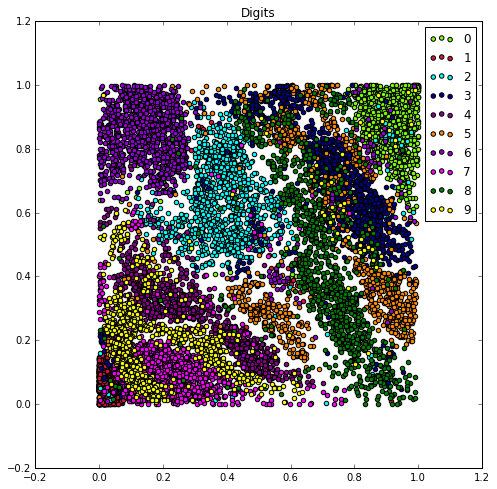

In [15]:
from sklearn.cross_validation import train_test_split
autoencoder.load_weights('./au5.chp')
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = autoencoder.transform(X_test)
print(X_transformed)
colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")


WITH DROPOUT relu in enc layers and sigmoid on dec layers
-------

In [10]:
from au import AutoEncoder

# Train Autoencoder
batch_size =30
epoch = 100
keep_prob_value = 0.9
# Autoencoder
autoencoder = AutoEncoder(784, [1000, 500,250,2],  [['rbmw1', 'rbmhb1'],
                                                ['rbmw2', 'rbmhb2'],
                                                ['rbmw3', 'rbmhb3'],
                                                   ['rbmw4', 'rbmhb4']],
                                           tied_weights=False,keep_prob=keep_prob_value)
# Load RBM weights to Autoencoder
autoencoder.load_rbm_weights('./rbmw1.chp', ['rbmw1', 'rbmhb1'], 0)
autoencoder.load_rbm_weights('./rbmw2.chp', ['rbmw2', 'rbmhb2'], 1)
autoencoder.load_rbm_weights('./rbmw3.chp', ['rbmw3', 'rbmhb3'], 2)
autoencoder.load_rbm_weights('./rbmw4.chp', ['rbmw4', 'rbmhb4'], 3)

interactions = int(math.floor(images.shape[0]/batch_size))
print('autoencoder')
for i in tqdm(range(epoch)):
    cost = 0.0
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        cost += autoencoder.partial_fit(batch_xs)
    print(i,'cost: ',cost)

autoencoder.save_weights('./au3.chp')


  0%|          | 0/100 [00:00<?, ?it/s]

autoencoder


  1%|          | 1/100 [00:09<14:54,  9.03s/it]

0 cost:  394.44010362


  2%|▏         | 2/100 [00:17<14:42,  9.01s/it]

1 cost:  382.273931056


  3%|▎         | 3/100 [00:26<14:31,  8.98s/it]

2 cost:  377.539147764


  4%|▍         | 4/100 [00:35<14:20,  8.96s/it]

3 cost:  376.15609701


  5%|▌         | 5/100 [00:44<14:10,  8.96s/it]

4 cost:  375.834994033


  6%|▌         | 6/100 [00:53<14:02,  8.96s/it]

5 cost:  375.61926274


  7%|▋         | 7/100 [01:02<13:52,  8.96s/it]

6 cost:  375.576319084


  8%|▊         | 8/100 [01:11<13:44,  8.97s/it]

7 cost:  375.5678996


  9%|▉         | 9/100 [01:20<13:37,  8.98s/it]

8 cost:  375.543069452


 10%|█         | 10/100 [01:29<13:28,  8.98s/it]

9 cost:  375.511430621


 11%|█         | 11/100 [01:38<13:19,  8.98s/it]

10 cost:  375.494652107


 12%|█▏        | 12/100 [01:47<13:09,  8.98s/it]

11 cost:  375.495613962


 13%|█▎        | 13/100 [01:56<13:00,  8.97s/it]

12 cost:  375.472498477


 14%|█▍        | 14/100 [02:05<12:51,  8.98s/it]

13 cost:  375.479590535


 15%|█▌        | 15/100 [02:14<12:42,  8.97s/it]

14 cost:  375.513657957


 16%|█▌        | 16/100 [02:23<12:33,  8.97s/it]

15 cost:  375.447856307


 17%|█▋        | 17/100 [02:32<12:25,  8.98s/it]

16 cost:  375.497737989


 18%|█▊        | 18/100 [02:41<12:16,  8.98s/it]

17 cost:  375.469834879


 19%|█▉        | 19/100 [02:50<12:07,  8.98s/it]

18 cost:  375.50014022


 20%|██        | 20/100 [02:59<11:58,  8.98s/it]

19 cost:  375.511837512


 21%|██        | 21/100 [03:08<11:49,  8.98s/it]

20 cost:  375.465134799


 22%|██▏       | 22/100 [03:17<11:40,  8.98s/it]

21 cost:  375.453989401


 23%|██▎       | 23/100 [03:26<11:30,  8.97s/it]

22 cost:  375.453070715


 24%|██▍       | 24/100 [03:35<11:21,  8.97s/it]

23 cost:  375.445010766


 25%|██▌       | 25/100 [03:44<11:12,  8.97s/it]

24 cost:  375.463351443


 26%|██▌       | 26/100 [03:53<11:03,  8.97s/it]

25 cost:  375.490405425


 27%|██▋       | 27/100 [04:02<10:54,  8.97s/it]

26 cost:  375.449129388


 28%|██▊       | 28/100 [04:11<10:45,  8.97s/it]

27 cost:  375.420360208


 29%|██▉       | 29/100 [04:20<10:36,  8.96s/it]

28 cost:  375.435665205


 30%|███       | 30/100 [04:29<10:27,  8.96s/it]

29 cost:  375.357956246


 31%|███       | 31/100 [04:38<10:18,  8.97s/it]

30 cost:  375.441593558


 32%|███▏      | 32/100 [04:47<10:10,  8.97s/it]

31 cost:  375.380758137


 33%|███▎      | 33/100 [04:56<10:00,  8.97s/it]

32 cost:  375.423060402


 34%|███▍      | 34/100 [05:04<09:51,  8.97s/it]

33 cost:  375.457392141


 35%|███▌      | 35/100 [05:13<09:43,  8.97s/it]

34 cost:  375.364766583


 36%|███▌      | 36/100 [05:22<09:33,  8.97s/it]

35 cost:  375.395151019


 37%|███▋      | 37/100 [05:31<09:24,  8.97s/it]

36 cost:  375.445158914


 38%|███▊      | 38/100 [05:40<09:15,  8.96s/it]

37 cost:  375.371794939


 39%|███▉      | 39/100 [05:49<09:06,  8.96s/it]

38 cost:  375.395660654


 40%|████      | 40/100 [05:58<08:57,  8.95s/it]

39 cost:  375.387199774


 41%|████      | 41/100 [06:07<08:48,  8.95s/it]

40 cost:  375.339580506


 42%|████▏     | 42/100 [06:16<08:38,  8.95s/it]

41 cost:  375.394561633


 43%|████▎     | 43/100 [06:25<08:29,  8.94s/it]

42 cost:  375.320327565


 44%|████▍     | 44/100 [06:34<08:20,  8.94s/it]

43 cost:  375.343151703


 45%|████▌     | 45/100 [06:43<08:11,  8.94s/it]

44 cost:  375.380638137


 46%|████▌     | 46/100 [06:52<08:02,  8.93s/it]

45 cost:  375.326606229


 47%|████▋     | 47/100 [07:01<07:53,  8.93s/it]

46 cost:  375.328755185


 48%|████▊     | 48/100 [07:10<07:44,  8.93s/it]

47 cost:  375.349100411


 49%|████▉     | 49/100 [07:19<07:35,  8.92s/it]

48 cost:  375.338496551


 50%|█████     | 50/100 [07:28<07:26,  8.92s/it]

49 cost:  375.307011187


 51%|█████     | 51/100 [07:36<07:17,  8.92s/it]

50 cost:  375.331598192


 52%|█████▏    | 52/100 [07:45<07:08,  8.92s/it]

51 cost:  375.331553474


 53%|█████▎    | 53/100 [07:54<06:59,  8.92s/it]

52 cost:  375.297544256


 54%|█████▍    | 54/100 [08:03<06:50,  8.92s/it]

53 cost:  375.354602352


 55%|█████▌    | 55/100 [08:12<06:41,  8.91s/it]

54 cost:  375.290017158


 56%|█████▌    | 56/100 [08:21<06:32,  8.91s/it]

55 cost:  375.302561402


 57%|█████▋    | 57/100 [08:30<06:23,  8.92s/it]

56 cost:  375.3370969


 58%|█████▊    | 58/100 [08:39<06:14,  8.91s/it]

57 cost:  375.284741268


 59%|█████▉    | 59/100 [08:48<06:05,  8.91s/it]

58 cost:  375.289607093


 60%|██████    | 60/100 [08:57<05:56,  8.91s/it]

59 cost:  375.318070233


 61%|██████    | 61/100 [09:06<05:47,  8.91s/it]

60 cost:  375.220096782


 62%|██████▏   | 62/100 [09:14<05:38,  8.91s/it]

61 cost:  375.298028067


 63%|██████▎   | 63/100 [09:23<05:29,  8.91s/it]

62 cost:  375.282234013


 64%|██████▍   | 64/100 [09:32<05:21,  8.92s/it]

63 cost:  375.320814237


 65%|██████▌   | 65/100 [09:41<05:12,  8.92s/it]

64 cost:  375.266873717


 66%|██████▌   | 66/100 [09:50<05:03,  8.92s/it]

65 cost:  375.274788871


 67%|██████▋   | 67/100 [09:59<04:54,  8.92s/it]

66 cost:  375.29073742


 68%|██████▊   | 68/100 [10:08<04:45,  8.92s/it]

67 cost:  375.240368918


 69%|██████▉   | 69/100 [10:17<04:36,  8.92s/it]

68 cost:  375.223768398


 70%|███████   | 70/100 [10:26<04:27,  8.92s/it]

69 cost:  375.270966277


 71%|███████   | 71/100 [10:35<04:18,  8.92s/it]

70 cost:  375.226406693


 72%|███████▏  | 72/100 [10:44<04:09,  8.92s/it]

71 cost:  375.254915386


 73%|███████▎  | 73/100 [10:53<04:00,  8.92s/it]

72 cost:  375.228330001


 74%|███████▍  | 74/100 [11:02<03:51,  8.92s/it]

73 cost:  375.270925939


 75%|███████▌  | 75/100 [11:10<03:42,  8.91s/it]

74 cost:  375.267806023


 76%|███████▌  | 76/100 [11:19<03:34,  8.92s/it]

75 cost:  375.257593617


 77%|███████▋  | 77/100 [11:28<03:25,  8.92s/it]

76 cost:  375.214031234


 78%|███████▊  | 78/100 [11:37<03:16,  8.91s/it]

77 cost:  375.214438781


 79%|███████▉  | 79/100 [11:46<03:07,  8.91s/it]

78 cost:  375.149787843


 80%|████████  | 80/100 [11:55<02:58,  8.90s/it]

79 cost:  375.232992873


 81%|████████  | 81/100 [12:04<02:49,  8.90s/it]

80 cost:  375.21533829


 82%|████████▏ | 82/100 [12:13<02:40,  8.90s/it]

81 cost:  375.211015567


 83%|████████▎ | 83/100 [12:22<02:31,  8.89s/it]

82 cost:  375.217232227


 84%|████████▍ | 84/100 [12:31<02:22,  8.89s/it]

83 cost:  375.189164534


 85%|████████▌ | 85/100 [12:39<02:13,  8.89s/it]

84 cost:  375.217927188


 86%|████████▌ | 86/100 [12:48<02:04,  8.88s/it]

85 cost:  375.239912078


 87%|████████▋ | 87/100 [12:57<01:55,  8.88s/it]

86 cost:  375.199832186


 88%|████████▊ | 88/100 [13:06<01:46,  8.89s/it]

87 cost:  375.171699703


 89%|████████▉ | 89/100 [13:15<01:37,  8.88s/it]

88 cost:  375.235965475


 90%|█████████ | 90/100 [13:24<01:28,  8.88s/it]

89 cost:  375.204195574


 91%|█████████ | 91/100 [13:33<01:20,  8.89s/it]

90 cost:  375.251093388


 92%|█████████▏| 92/100 [13:42<01:11,  8.89s/it]

91 cost:  375.182490706


 93%|█████████▎| 93/100 [13:50<01:02,  8.89s/it]

92 cost:  375.1794523


 94%|█████████▍| 94/100 [13:59<00:53,  8.88s/it]

93 cost:  375.16509302


 95%|█████████▌| 95/100 [14:08<00:44,  8.88s/it]

94 cost:  375.206833601


 96%|█████████▌| 96/100 [14:17<00:35,  8.89s/it]

95 cost:  375.23018305


 97%|█████████▋| 97/100 [14:26<00:26,  8.89s/it]

96 cost:  375.136986598


 98%|█████████▊| 98/100 [14:35<00:17,  8.89s/it]

97 cost:  375.222912729


 99%|█████████▉| 99/100 [14:44<00:08,  8.90s/it]

98 cost:  375.241525128


100%|██████████| 100/100 [14:53<00:00,  8.91s/it]

99 cost:  375.245823756


[[ 27391.32617188  25726.57421875]
 [  7764.14257812   7374.29052734]
 [ 23433.18554688  21871.48828125]
 ..., 
 [ 15959.90820312  15085.41894531]
 [ 44503.25390625  42341.48046875]
 [ 31125.23828125  29391.328125  ]]


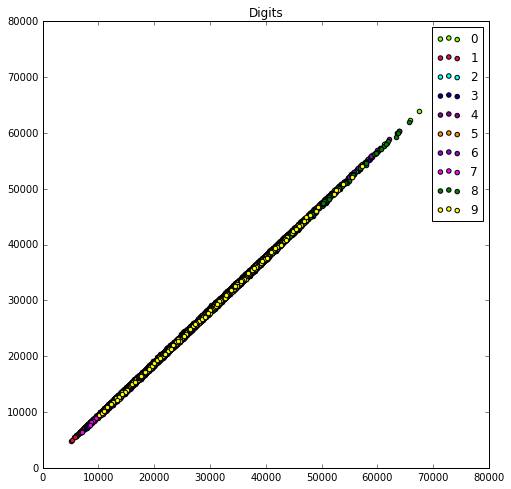

In [11]:
from sklearn.cross_validation import train_test_split
autoencoder.load_weights('./au3.chp')
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = autoencoder.transform(X_test)
print(X_transformed)
colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")


WITH DROPOUT relu in enc layers and sigmoid on dec layers and L2 Regularization
-------

In [16]:
from au import AutoEncoder

# Train Autoencoder
batch_size =30
epoch = 100
keep_prob_value = 0.9
# Autoencoder
autoencoder = AutoEncoder(784, [1000, 500,250,2],  [['rbmw1', 'rbmhb1'],
                                                ['rbmw2', 'rbmhb2'],
                                                ['rbmw3', 'rbmhb3'],
                                                   ['rbmw4', 'rbmhb4']],
                                           tied_weights=False,keep_prob=keep_prob_value,regtype='l2')
# Load RBM weights to Autoencoder
autoencoder.load_rbm_weights('./rbmw1.chp', ['rbmw1', 'rbmhb1'], 0)
autoencoder.load_rbm_weights('./rbmw2.chp', ['rbmw2', 'rbmhb2'], 1)
autoencoder.load_rbm_weights('./rbmw3.chp', ['rbmw3', 'rbmhb3'], 2)
autoencoder.load_rbm_weights('./rbmw4.chp', ['rbmw4', 'rbmhb4'], 3)

interactions = int(math.floor(images.shape[0]/batch_size))
print('autoencoder')
for i in tqdm(range(epoch)):
    cost = 0.0
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        cost += autoencoder.partial_fit(batch_xs)
    print(i,'cost: ',cost)

autoencoder.save_weights('./au4.chp')


  0%|          | 0/100 [00:00<?, ?it/s]

autoencoder


  1%|          | 1/100 [00:09<15:55,  9.65s/it]

0 cost:  9509.00416851


  2%|▏         | 2/100 [00:19<15:46,  9.65s/it]

1 cost:  1825.47857696


  3%|▎         | 3/100 [00:28<15:36,  9.65s/it]

2 cost:  696.257153809


  4%|▍         | 4/100 [00:38<15:23,  9.62s/it]

3 cost:  417.328423306


  5%|▌         | 5/100 [00:48<15:14,  9.63s/it]

4 cost:  356.945357814


  6%|▌         | 6/100 [00:57<15:05,  9.63s/it]

5 cost:  343.45950447


  7%|▋         | 7/100 [01:07<14:55,  9.63s/it]

6 cost:  340.397385165


  8%|▊         | 8/100 [01:17<14:46,  9.64s/it]

7 cost:  338.637844473


  9%|▉         | 9/100 [01:26<14:37,  9.64s/it]

8 cost:  337.777584225


 10%|█         | 10/100 [01:36<14:28,  9.65s/it]

9 cost:  337.042914763


 11%|█         | 11/100 [01:46<14:18,  9.65s/it]

10 cost:  336.270987436


 12%|█▏        | 12/100 [01:55<14:08,  9.65s/it]

11 cost:  335.860360548


 13%|█▎        | 13/100 [02:05<13:59,  9.65s/it]

12 cost:  335.661040261


 14%|█▍        | 14/100 [02:14<13:49,  9.64s/it]

13 cost:  335.075949594


 15%|█▌        | 15/100 [02:24<13:39,  9.64s/it]

14 cost:  334.767849922


 16%|█▌        | 16/100 [02:34<13:29,  9.64s/it]

15 cost:  334.626230061


 17%|█▋        | 17/100 [02:43<13:20,  9.64s/it]

16 cost:  334.179383993


 18%|█▊        | 18/100 [02:53<13:10,  9.64s/it]

17 cost:  334.032815635


 19%|█▉        | 19/100 [03:03<13:01,  9.65s/it]

18 cost:  334.487044856


 20%|██        | 20/100 [03:12<12:51,  9.65s/it]

19 cost:  333.833442643


 21%|██        | 21/100 [03:22<12:41,  9.64s/it]

20 cost:  333.869653225


 22%|██▏       | 22/100 [03:32<12:32,  9.64s/it]

21 cost:  333.699051157


 23%|██▎       | 23/100 [03:41<12:22,  9.64s/it]

22 cost:  333.390013114


 24%|██▍       | 24/100 [03:51<12:12,  9.64s/it]

23 cost:  333.488436893


 25%|██▌       | 25/100 [04:01<12:03,  9.64s/it]

24 cost:  333.53160882


 26%|██▌       | 26/100 [04:10<11:53,  9.64s/it]

25 cost:  333.649516329


 27%|██▋       | 27/100 [04:20<11:43,  9.64s/it]

26 cost:  333.266332641


 28%|██▊       | 28/100 [04:29<11:34,  9.64s/it]

27 cost:  333.065596506


 29%|██▉       | 29/100 [04:39<11:24,  9.64s/it]

28 cost:  333.391872272


 30%|███       | 30/100 [04:49<11:14,  9.64s/it]

29 cost:  332.993534014


 31%|███       | 31/100 [04:58<11:05,  9.64s/it]

30 cost:  332.467403844


 32%|███▏      | 32/100 [05:08<10:55,  9.64s/it]

31 cost:  332.749062955


 33%|███▎      | 33/100 [05:18<10:45,  9.64s/it]

32 cost:  332.652365685


 34%|███▍      | 34/100 [05:27<10:36,  9.64s/it]

33 cost:  332.573108718


 35%|███▌      | 35/100 [05:37<10:26,  9.64s/it]

34 cost:  332.458448768


 36%|███▌      | 36/100 [05:47<10:17,  9.65s/it]

35 cost:  332.820460781


 37%|███▋      | 37/100 [05:56<10:07,  9.65s/it]

36 cost:  332.418116316


 38%|███▊      | 38/100 [06:06<09:57,  9.64s/it]

37 cost:  332.428420812


 39%|███▉      | 39/100 [06:16<09:48,  9.64s/it]

38 cost:  332.0106242


 40%|████      | 40/100 [06:25<09:38,  9.65s/it]

39 cost:  332.467341527


 41%|████      | 41/100 [06:35<09:29,  9.65s/it]

40 cost:  331.938564122


 42%|████▏     | 42/100 [06:44<09:19,  9.64s/it]

41 cost:  332.303124934


 43%|████▎     | 43/100 [06:54<09:09,  9.65s/it]

42 cost:  331.683298275


 44%|████▍     | 44/100 [07:04<09:00,  9.65s/it]

43 cost:  332.765792355


 45%|████▌     | 45/100 [07:13<08:51,  9.66s/it]

44 cost:  332.237598911


 46%|████▌     | 46/100 [07:23<08:41,  9.66s/it]

45 cost:  332.263356179


 47%|████▋     | 47/100 [07:33<08:31,  9.66s/it]

46 cost:  331.86862506


 48%|████▊     | 48/100 [07:42<08:22,  9.66s/it]

47 cost:  332.128931671


 49%|████▉     | 49/100 [07:52<08:12,  9.65s/it]

48 cost:  331.975455225


 50%|█████     | 50/100 [08:02<08:02,  9.65s/it]

49 cost:  332.286557242


 51%|█████     | 51/100 [08:11<07:53,  9.66s/it]

50 cost:  332.296129808


 52%|█████▏    | 52/100 [08:21<07:43,  9.66s/it]

51 cost:  331.859219924


 53%|█████▎    | 53/100 [08:31<07:33,  9.65s/it]

52 cost:  332.200336114


 54%|█████▍    | 54/100 [08:40<07:23,  9.65s/it]

53 cost:  331.938269451


 55%|█████▌    | 55/100 [08:50<07:14,  9.66s/it]

54 cost:  332.30092366


 56%|█████▌    | 56/100 [09:00<07:04,  9.66s/it]

55 cost:  331.25869821


 57%|█████▋    | 57/100 [09:09<06:55,  9.66s/it]

56 cost:  332.282270774


 58%|█████▊    | 58/100 [09:19<06:45,  9.65s/it]

57 cost:  332.237331033


 59%|█████▉    | 59/100 [09:29<06:35,  9.65s/it]

58 cost:  331.715563729


 60%|██████    | 60/100 [09:38<06:26,  9.65s/it]

59 cost:  332.037946403


 61%|██████    | 61/100 [09:48<06:16,  9.65s/it]

60 cost:  332.183833331


 62%|██████▏   | 62/100 [09:58<06:06,  9.65s/it]

61 cost:  332.09791775


 63%|██████▎   | 63/100 [10:07<05:56,  9.65s/it]

62 cost:  331.959093988


 64%|██████▍   | 64/100 [10:17<05:47,  9.65s/it]

63 cost:  332.074514031


 65%|██████▌   | 65/100 [10:27<05:37,  9.66s/it]

64 cost:  332.367964506


 66%|██████▌   | 66/100 [10:36<05:28,  9.66s/it]

65 cost:  332.414090499


 67%|██████▋   | 67/100 [10:46<05:18,  9.65s/it]

66 cost:  331.812922075


 68%|██████▊   | 68/100 [10:56<05:09,  9.66s/it]

67 cost:  332.197289795


 69%|██████▉   | 69/100 [11:05<04:59,  9.66s/it]

68 cost:  332.021957219


 70%|███████   | 70/100 [11:15<04:49,  9.66s/it]

69 cost:  331.441890284


 71%|███████   | 71/100 [11:24<04:39,  9.65s/it]

70 cost:  332.472897932


 72%|███████▏  | 72/100 [11:34<04:30,  9.66s/it]

71 cost:  332.312511861


 73%|███████▎  | 73/100 [11:44<04:20,  9.66s/it]

72 cost:  331.458558127


 74%|███████▍  | 74/100 [11:53<04:11,  9.66s/it]

73 cost:  332.200571895


 75%|███████▌  | 75/100 [12:03<04:01,  9.66s/it]

74 cost:  332.1589306


 76%|███████▌  | 76/100 [12:13<03:51,  9.66s/it]

75 cost:  331.477785051


 77%|███████▋  | 77/100 [12:22<03:42,  9.67s/it]

76 cost:  331.412855372


 78%|███████▊  | 78/100 [12:32<03:32,  9.66s/it]

77 cost:  331.851923168


 79%|███████▉  | 79/100 [12:42<03:22,  9.65s/it]

78 cost:  332.027250618


 80%|████████  | 80/100 [12:51<03:13,  9.65s/it]

79 cost:  331.926881313


 81%|████████  | 81/100 [13:01<03:03,  9.66s/it]

80 cost:  332.256405666


 82%|████████▏ | 82/100 [13:11<02:53,  9.66s/it]

81 cost:  332.566944957


 83%|████████▎ | 83/100 [13:20<02:44,  9.65s/it]

82 cost:  331.599300086


 84%|████████▍ | 84/100 [13:30<02:34,  9.66s/it]

83 cost:  331.756363168


 85%|████████▌ | 85/100 [13:40<02:24,  9.66s/it]

84 cost:  331.914558426


 86%|████████▌ | 86/100 [13:49<02:15,  9.66s/it]

85 cost:  331.59812735


 87%|████████▋ | 87/100 [13:59<02:05,  9.67s/it]

86 cost:  331.741896585


 88%|████████▊ | 88/100 [14:09<01:56,  9.67s/it]

87 cost:  332.328369573


 89%|████████▉ | 89/100 [14:18<01:46,  9.67s/it]

88 cost:  331.606112614


 90%|█████████ | 90/100 [14:28<01:36,  9.66s/it]

89 cost:  330.890060753


 91%|█████████ | 91/100 [14:38<01:27,  9.67s/it]

90 cost:  331.323474109


 92%|█████████▏| 92/100 [14:47<01:17,  9.67s/it]

91 cost:  332.40029262


 93%|█████████▎| 93/100 [14:57<01:07,  9.68s/it]

92 cost:  331.320346013


 94%|█████████▍| 94/100 [15:07<00:58,  9.68s/it]

93 cost:  331.622812748


 95%|█████████▌| 95/100 [15:16<00:48,  9.68s/it]

94 cost:  331.432552278


 96%|█████████▌| 96/100 [15:26<00:38,  9.68s/it]

95 cost:  331.888855204


 97%|█████████▋| 97/100 [15:36<00:29,  9.68s/it]

96 cost:  332.006864041


 98%|█████████▊| 98/100 [15:46<00:19,  9.69s/it]

97 cost:  332.305450916


 99%|█████████▉| 99/100 [15:55<00:09,  9.69s/it]

98 cost:  331.802536547


100%|██████████| 100/100 [16:05<00:00,  9.69s/it]

99 cost:  332.039643973


[[ 0.56438994  0.56369889]
 [ 0.29189798  0.24470854]
 [ 0.45989618  0.57876527]
 ..., 
 [ 0.48133463  0.42483321]
 [ 1.12639987  0.69568759]
 [ 1.36406326  2.268996  ]]


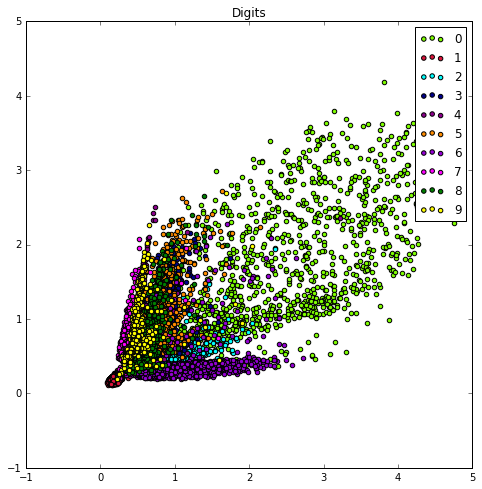

In [17]:
from sklearn.cross_validation import train_test_split
autoencoder.load_weights('./au4.chp')
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = autoencoder.transform(X_test)
print(X_transformed)
colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")


WITHOUT DROPOUT relu in enc layers and sigmoid on dec layers and L2 Regularization
-------

In [18]:
from au import AutoEncoder

# Train Autoencoder
batch_size =30
epoch = 100
keep_prob_value = 1
# Autoencoder
autoencoder = AutoEncoder(784, [1000, 500,250,2],  [['rbmw1', 'rbmhb1'],
                                                ['rbmw2', 'rbmhb2'],
                                                ['rbmw3', 'rbmhb3'],
                                                   ['rbmw4', 'rbmhb4']],
                                           tied_weights=False,keep_prob=keep_prob_value,regtype='l2')
# Load RBM weights to Autoencoder
autoencoder.load_rbm_weights('./rbmw1.chp', ['rbmw1', 'rbmhb1'], 0)
autoencoder.load_rbm_weights('./rbmw2.chp', ['rbmw2', 'rbmhb2'], 1)
autoencoder.load_rbm_weights('./rbmw3.chp', ['rbmw3', 'rbmhb3'], 2)
autoencoder.load_rbm_weights('./rbmw4.chp', ['rbmw4', 'rbmhb4'], 3)

interactions = int(math.floor(images.shape[0]/batch_size))
print('autoencoder')
for i in tqdm(range(epoch)):
    cost = 0.0
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        cost += autoencoder.partial_fit(batch_xs)
    print(i,'cost: ',cost)

autoencoder.save_weights('./au6.chp')


  0%|          | 0/100 [00:00<?, ?it/s]

autoencoder


  1%|          | 1/100 [00:09<16:05,  9.75s/it]

0 cost:  9487.51042104


  2%|▏         | 2/100 [00:19<15:55,  9.75s/it]

1 cost:  1785.64404762


  3%|▎         | 3/100 [00:29<15:46,  9.75s/it]

2 cost:  656.745920211


  4%|▍         | 4/100 [00:39<15:36,  9.75s/it]

3 cost:  375.071812093


  5%|▌         | 5/100 [00:48<15:26,  9.75s/it]

4 cost:  311.952200323


  6%|▌         | 6/100 [00:58<15:17,  9.76s/it]

5 cost:  298.718100041


  7%|▋         | 7/100 [01:08<15:08,  9.77s/it]

6 cost:  294.5205369


  8%|▊         | 8/100 [01:18<14:59,  9.78s/it]

7 cost:  292.971150503


  9%|▉         | 9/100 [01:27<14:49,  9.78s/it]

8 cost:  291.413371131


 10%|█         | 10/100 [01:37<14:40,  9.78s/it]

9 cost:  290.692249537


 11%|█         | 11/100 [01:47<14:29,  9.77s/it]

10 cost:  289.532558084


 12%|█▏        | 12/100 [01:57<14:20,  9.78s/it]

11 cost:  289.011958286


 13%|█▎        | 13/100 [02:07<14:11,  9.78s/it]

12 cost:  288.055932313


 14%|█▍        | 14/100 [02:16<14:01,  9.78s/it]

13 cost:  287.749429226


 15%|█▌        | 15/100 [02:26<13:50,  9.78s/it]

14 cost:  287.190592512


 16%|█▌        | 16/100 [02:36<13:40,  9.77s/it]

15 cost:  286.926219687


 17%|█▋        | 17/100 [02:46<13:31,  9.78s/it]

16 cost:  286.736398965


 18%|█▊        | 18/100 [02:55<13:21,  9.78s/it]

17 cost:  286.260156393


 19%|█▉        | 19/100 [03:05<13:12,  9.78s/it]

18 cost:  286.272581592


 20%|██        | 20/100 [03:15<13:02,  9.79s/it]

19 cost:  285.824919522


 21%|██        | 21/100 [03:25<12:53,  9.79s/it]

20 cost:  286.22369723


 22%|██▏       | 22/100 [03:35<12:42,  9.78s/it]

21 cost:  285.84911482


 23%|██▎       | 23/100 [03:44<12:33,  9.79s/it]

22 cost:  285.573091552


 24%|██▍       | 24/100 [03:54<12:23,  9.78s/it]

23 cost:  285.32759808


 25%|██▌       | 25/100 [04:04<12:13,  9.78s/it]

24 cost:  285.479632482


 26%|██▌       | 26/100 [04:14<12:03,  9.78s/it]

25 cost:  284.989887685


 27%|██▋       | 27/100 [04:23<11:54,  9.78s/it]

26 cost:  284.923346326


 28%|██▊       | 28/100 [04:33<11:44,  9.79s/it]

27 cost:  285.118512347


 29%|██▉       | 29/100 [04:43<11:34,  9.79s/it]

28 cost:  284.412598461


 30%|███       | 30/100 [04:53<11:25,  9.79s/it]

29 cost:  284.720553443


 31%|███       | 31/100 [05:03<11:15,  9.78s/it]

30 cost:  284.282455787


 32%|███▏      | 32/100 [05:12<11:05,  9.79s/it]

31 cost:  284.312254012


 33%|███▎      | 33/100 [05:22<10:55,  9.78s/it]

32 cost:  284.36437951


 34%|███▍      | 34/100 [05:32<10:46,  9.79s/it]

33 cost:  284.536865711


 35%|███▌      | 35/100 [05:42<10:36,  9.79s/it]

34 cost:  284.438005134


 36%|███▌      | 36/100 [05:52<10:26,  9.79s/it]

35 cost:  284.670979589


 37%|███▋      | 37/100 [06:01<10:17,  9.80s/it]

36 cost:  284.280046195


 38%|███▊      | 38/100 [06:11<10:07,  9.80s/it]

37 cost:  284.02237837


 39%|███▉      | 39/100 [06:21<09:58,  9.81s/it]

38 cost:  284.127927646


 40%|████      | 40/100 [06:31<09:48,  9.81s/it]

39 cost:  283.461997181


 41%|████      | 41/100 [06:41<09:39,  9.82s/it]

40 cost:  283.879900947


 42%|████▏     | 42/100 [06:50<09:29,  9.82s/it]

41 cost:  284.362745062


 43%|████▎     | 43/100 [07:00<09:19,  9.82s/it]

42 cost:  283.591709793


 44%|████▍     | 44/100 [07:10<09:09,  9.82s/it]

43 cost:  283.406157702


 45%|████▌     | 45/100 [07:20<09:00,  9.82s/it]

44 cost:  283.660796329


 46%|████▌     | 46/100 [07:30<08:50,  9.82s/it]

45 cost:  283.236874506


 47%|████▋     | 47/100 [07:40<08:40,  9.83s/it]

46 cost:  283.077750862


 48%|████▊     | 48/100 [07:49<08:31,  9.83s/it]

47 cost:  283.700801417


 49%|████▉     | 49/100 [07:59<08:21,  9.82s/it]

48 cost:  283.795993313


 50%|█████     | 50/100 [08:09<08:11,  9.82s/it]

49 cost:  283.864036232


 51%|█████     | 51/100 [08:19<08:01,  9.82s/it]

50 cost:  283.451617062


 52%|█████▏    | 52/100 [08:29<07:51,  9.82s/it]

51 cost:  284.081012204


 53%|█████▎    | 53/100 [08:39<07:41,  9.82s/it]

52 cost:  284.186547503


 54%|█████▍    | 54/100 [08:48<07:31,  9.82s/it]

53 cost:  282.79172042


 55%|█████▌    | 55/100 [08:58<07:21,  9.82s/it]

54 cost:  283.333855271


 56%|█████▌    | 56/100 [09:08<07:12,  9.83s/it]

55 cost:  283.505340338


 57%|█████▋    | 57/100 [09:18<07:02,  9.82s/it]

56 cost:  283.13116537


 58%|█████▊    | 58/100 [09:28<06:52,  9.82s/it]

57 cost:  283.310404345


 59%|█████▉    | 59/100 [09:37<06:42,  9.83s/it]

58 cost:  282.841011718


 60%|██████    | 60/100 [09:47<06:33,  9.83s/it]

59 cost:  283.64806819


 61%|██████    | 61/100 [09:57<06:23,  9.83s/it]

60 cost:  283.453861743


 62%|██████▏   | 62/100 [10:07<06:13,  9.82s/it]

61 cost:  283.209793389


 63%|██████▎   | 63/100 [10:17<06:03,  9.83s/it]

62 cost:  282.939411044


 64%|██████▍   | 64/100 [10:27<05:53,  9.83s/it]

63 cost:  283.480021194


 65%|██████▌   | 65/100 [10:36<05:43,  9.82s/it]

64 cost:  284.266616926


 66%|██████▌   | 66/100 [10:46<05:34,  9.83s/it]

65 cost:  283.079705462


 67%|██████▋   | 67/100 [10:56<05:24,  9.82s/it]

66 cost:  283.523592442


 68%|██████▊   | 68/100 [11:06<05:14,  9.83s/it]

67 cost:  282.901342943


 69%|██████▉   | 69/100 [11:16<05:04,  9.83s/it]

68 cost:  283.152594686


 70%|███████   | 70/100 [11:26<04:54,  9.83s/it]

69 cost:  283.034764096


 71%|███████   | 71/100 [11:35<04:45,  9.83s/it]

70 cost:  283.135047838


 72%|███████▏  | 72/100 [11:45<04:35,  9.83s/it]

71 cost:  284.317630425


 73%|███████▎  | 73/100 [11:55<04:25,  9.83s/it]

72 cost:  283.405615121


 74%|███████▍  | 74/100 [12:05<04:15,  9.83s/it]

73 cost:  283.130844563


 75%|███████▌  | 75/100 [12:15<04:05,  9.83s/it]

74 cost:  284.056257814


 76%|███████▌  | 76/100 [12:25<03:56,  9.83s/it]

75 cost:  283.1148341


 77%|███████▋  | 77/100 [12:34<03:46,  9.83s/it]

76 cost:  283.565909728


 78%|███████▊  | 78/100 [12:44<03:36,  9.84s/it]

77 cost:  283.337714776


 79%|███████▉  | 79/100 [12:54<03:26,  9.84s/it]

78 cost:  283.309864834


 80%|████████  | 80/100 [13:04<03:16,  9.84s/it]

79 cost:  283.303151876


 81%|████████  | 81/100 [13:14<03:06,  9.84s/it]

80 cost:  283.746270329


 82%|████████▏ | 82/100 [13:24<02:57,  9.84s/it]

81 cost:  282.758542195


 83%|████████▎ | 83/100 [13:33<02:47,  9.84s/it]

82 cost:  283.597593546


 84%|████████▍ | 84/100 [13:43<02:37,  9.84s/it]

83 cost:  283.704426587


 85%|████████▌ | 85/100 [13:53<02:27,  9.83s/it]

84 cost:  283.161685392


 86%|████████▌ | 86/100 [14:03<02:17,  9.84s/it]

85 cost:  283.628195345


 87%|████████▋ | 87/100 [14:13<02:07,  9.83s/it]

86 cost:  283.117496029


 88%|████████▊ | 88/100 [14:23<01:57,  9.83s/it]

87 cost:  283.570401788


 89%|████████▉ | 89/100 [14:32<01:48,  9.83s/it]

88 cost:  282.978239909


 90%|█████████ | 90/100 [14:42<01:38,  9.83s/it]

89 cost:  284.156495199


 91%|█████████ | 91/100 [14:52<01:28,  9.83s/it]

90 cost:  283.256894469


 92%|█████████▏| 92/100 [15:02<01:18,  9.83s/it]

91 cost:  282.3978194


 93%|█████████▎| 93/100 [15:12<01:08,  9.83s/it]

92 cost:  283.143090099


 94%|█████████▍| 94/100 [15:22<00:58,  9.83s/it]

93 cost:  282.586312905


 95%|█████████▌| 95/100 [15:31<00:49,  9.83s/it]

94 cost:  283.079710752


 96%|█████████▌| 96/100 [15:41<00:39,  9.83s/it]

95 cost:  282.674734235


 97%|█████████▋| 97/100 [15:51<00:29,  9.83s/it]

96 cost:  282.98669681


 98%|█████████▊| 98/100 [16:01<00:19,  9.83s/it]

97 cost:  282.124476403


 99%|█████████▉| 99/100 [16:11<00:09,  9.84s/it]

98 cost:  283.321581259


100%|██████████| 100/100 [16:21<00:00,  9.84s/it]

99 cost:  282.038276121


[[ 0.16445543  0.17958431]
 [ 0.09439987  0.1310578 ]
 [ 0.15490904  0.25380829]
 ..., 
 [ 0.17636663  0.13782251]
 [ 0.29492232  0.13075319]
 [ 0.44921267  0.24281898]]


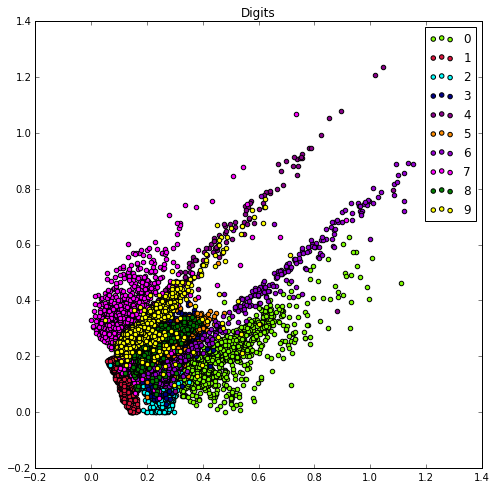

In [19]:
from sklearn.cross_validation import train_test_split
autoencoder.load_weights('./au6.chp')
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = autoencoder.transform(X_test)
print(X_transformed)
colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")


WITH DROPOUT sigmoid in enc layers and sigmoid on dec layers and L2 Regularization
-------

In [20]:
from au import AutoEncoder

# Train Autoencoder
batch_size =30
epoch = 100
keep_prob_value = 0.9
# Autoencoder
autoencoder = AutoEncoder(784, [1000, 500,250,2],  [['rbmw1', 'rbmhb1'],
                                                ['rbmw2', 'rbmhb2'],
                                                ['rbmw3', 'rbmhb3'],
                                                   ['rbmw4', 'rbmhb4']],
                                           tied_weights=False,keep_prob=keep_prob_value,regtype='l2',
                                          transfer_function_enc=tf.nn.sigmoid,
                                          transfer_function_dec=tf.nn.sigmoid)
# Load RBM weights to Autoencoder
autoencoder.load_rbm_weights('./rbmw1.chp', ['rbmw1', 'rbmhb1'], 0)
autoencoder.load_rbm_weights('./rbmw2.chp', ['rbmw2', 'rbmhb2'], 1)
autoencoder.load_rbm_weights('./rbmw3.chp', ['rbmw3', 'rbmhb3'], 2)
autoencoder.load_rbm_weights('./rbmw4.chp', ['rbmw4', 'rbmhb4'], 3)

interactions = int(math.floor(images.shape[0]/batch_size))
print('autoencoder')
for i in tqdm(range(epoch)):
    cost = 0.0
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        cost += autoencoder.partial_fit(batch_xs)
    print(i,'cost: ',cost)

autoencoder.save_weights('./au7.chp')


  0%|          | 0/100 [00:00<?, ?it/s]

autoencoder


  1%|          | 1/100 [00:09<15:55,  9.65s/it]

0 cost:  9450.23290038


  2%|▏         | 2/100 [00:19<15:41,  9.61s/it]

1 cost:  1816.90886384


  3%|▎         | 3/100 [00:28<15:31,  9.61s/it]

2 cost:  707.644838363


  4%|▍         | 4/100 [00:38<15:21,  9.60s/it]

3 cost:  438.473620117


  5%|▌         | 5/100 [00:47<15:11,  9.60s/it]

4 cost:  382.674239308


  6%|▌         | 6/100 [00:57<15:02,  9.60s/it]

5 cost:  373.53036654


  7%|▋         | 7/100 [01:07<14:53,  9.60s/it]

6 cost:  372.090412244


  8%|▊         | 8/100 [01:16<14:43,  9.61s/it]

7 cost:  372.057284415


  9%|▉         | 9/100 [01:26<14:34,  9.61s/it]

8 cost:  371.763521641


 10%|█         | 10/100 [01:36<14:24,  9.61s/it]

9 cost:  371.926464498


 11%|█         | 11/100 [01:45<14:15,  9.62s/it]

10 cost:  371.951495007


 12%|█▏        | 12/100 [01:55<14:05,  9.61s/it]

11 cost:  371.632626221


 13%|█▎        | 13/100 [02:04<13:56,  9.62s/it]

12 cost:  371.617192999


 14%|█▍        | 14/100 [02:14<13:47,  9.62s/it]

13 cost:  371.546737298


 15%|█▌        | 15/100 [02:24<13:37,  9.62s/it]

14 cost:  371.108857259


 16%|█▌        | 16/100 [02:33<13:28,  9.63s/it]

15 cost:  369.594142705


 17%|█▋        | 17/100 [02:43<13:19,  9.63s/it]

16 cost:  368.439268857


 18%|█▊        | 18/100 [02:53<13:09,  9.63s/it]

17 cost:  368.211442769


 19%|█▉        | 19/100 [03:02<13:00,  9.64s/it]

18 cost:  367.922530636


 20%|██        | 20/100 [03:12<12:50,  9.63s/it]

19 cost:  367.579331279


 21%|██        | 21/100 [03:21<12:40,  9.63s/it]

20 cost:  367.639825806


 22%|██▏       | 22/100 [03:31<12:30,  9.63s/it]

21 cost:  367.660411671


 23%|██▎       | 23/100 [03:41<12:20,  9.62s/it]

22 cost:  367.532781959


 24%|██▍       | 24/100 [03:50<12:11,  9.62s/it]

23 cost:  367.378766641


 25%|██▌       | 25/100 [04:00<12:02,  9.63s/it]

24 cost:  367.250440314


 26%|██▌       | 26/100 [04:10<11:52,  9.63s/it]

25 cost:  367.123501182


 27%|██▋       | 27/100 [04:19<11:42,  9.63s/it]

26 cost:  367.14101094


 28%|██▊       | 28/100 [04:29<11:33,  9.63s/it]

27 cost:  367.143493384


 29%|██▉       | 29/100 [04:38<11:23,  9.62s/it]

28 cost:  367.348489776


 30%|███       | 30/100 [04:48<11:13,  9.62s/it]

29 cost:  367.147808075


 31%|███       | 31/100 [04:58<11:04,  9.63s/it]

30 cost:  366.959185585


 32%|███▏      | 32/100 [05:07<10:54,  9.62s/it]

31 cost:  366.985276535


 33%|███▎      | 33/100 [05:17<10:45,  9.63s/it]

32 cost:  366.990801722


 34%|███▍      | 34/100 [05:27<10:35,  9.63s/it]

33 cost:  366.68594186


 35%|███▌      | 35/100 [05:36<10:26,  9.63s/it]

34 cost:  366.949673921


 36%|███▌      | 36/100 [05:46<10:16,  9.64s/it]

35 cost:  367.263132721


 37%|███▋      | 37/100 [05:55<10:06,  9.63s/it]

36 cost:  367.082738504


 38%|███▊      | 38/100 [06:05<09:57,  9.64s/it]

37 cost:  366.760248289


 39%|███▉      | 39/100 [06:15<09:48,  9.64s/it]

38 cost:  366.822176918


 40%|████      | 40/100 [06:24<09:38,  9.64s/it]

39 cost:  366.837859735


 41%|████      | 41/100 [06:34<09:28,  9.64s/it]

40 cost:  366.965380758


 42%|████▏     | 42/100 [06:44<09:19,  9.64s/it]

41 cost:  366.696829215


 43%|████▎     | 43/100 [06:53<09:09,  9.64s/it]

42 cost:  366.681115791


 44%|████▍     | 44/100 [07:03<08:59,  9.64s/it]

43 cost:  366.772692844


 45%|████▌     | 45/100 [07:13<08:49,  9.64s/it]

44 cost:  366.721487403


 46%|████▌     | 46/100 [07:22<08:40,  9.64s/it]

45 cost:  366.581201389


 47%|████▋     | 47/100 [07:32<08:30,  9.64s/it]

46 cost:  366.795690313


 48%|████▊     | 48/100 [07:42<08:21,  9.64s/it]

47 cost:  366.533845276


 49%|████▉     | 49/100 [07:51<08:11,  9.64s/it]

48 cost:  366.786237121


 50%|█████     | 50/100 [08:01<08:01,  9.64s/it]

49 cost:  366.593352437


 51%|█████     | 51/100 [08:10<07:52,  9.64s/it]

50 cost:  366.614618808


 52%|█████▏    | 52/100 [08:20<07:42,  9.64s/it]

51 cost:  366.630993962


 53%|█████▎    | 53/100 [08:30<07:33,  9.64s/it]

52 cost:  366.960626662


 54%|█████▍    | 54/100 [08:39<07:23,  9.64s/it]

53 cost:  366.568786979


 55%|█████▌    | 55/100 [08:49<07:13,  9.64s/it]

54 cost:  366.696131721


 56%|█████▌    | 56/100 [08:59<07:04,  9.64s/it]

55 cost:  366.651232257


 57%|█████▋    | 57/100 [09:08<06:54,  9.64s/it]

56 cost:  366.422516629


 58%|█████▊    | 58/100 [09:18<06:44,  9.64s/it]

57 cost:  366.41083689


 59%|█████▉    | 59/100 [09:28<06:35,  9.64s/it]

58 cost:  366.611225009


 60%|██████    | 60/100 [09:37<06:25,  9.64s/it]

59 cost:  366.509980544


 61%|██████    | 61/100 [09:47<06:16,  9.64s/it]

60 cost:  366.388881281


 62%|██████▏   | 62/100 [09:56<06:06,  9.64s/it]

61 cost:  366.496207237


 63%|██████▎   | 63/100 [10:06<05:56,  9.64s/it]

62 cost:  366.448339254


 64%|██████▍   | 64/100 [10:16<05:47,  9.64s/it]

63 cost:  366.509223878


 65%|██████▌   | 65/100 [10:25<05:37,  9.64s/it]

64 cost:  366.500054508


 66%|██████▌   | 66/100 [10:35<05:27,  9.64s/it]

65 cost:  366.271573633


 67%|██████▋   | 67/100 [10:45<05:18,  9.64s/it]

66 cost:  366.347707793


 68%|██████▊   | 68/100 [10:54<05:08,  9.64s/it]

67 cost:  366.593241915


 69%|██████▉   | 69/100 [11:04<04:58,  9.64s/it]

68 cost:  366.526004553


 70%|███████   | 70/100 [11:14<04:49,  9.64s/it]

69 cost:  366.334769994


 71%|███████   | 71/100 [11:23<04:39,  9.63s/it]

70 cost:  366.211420834


 72%|███████▏  | 72/100 [11:33<04:29,  9.64s/it]

71 cost:  366.613373131


 73%|███████▎  | 73/100 [11:43<04:20,  9.64s/it]

72 cost:  366.539729521


 74%|███████▍  | 74/100 [11:52<04:10,  9.64s/it]

73 cost:  366.460695177


 75%|███████▌  | 75/100 [12:02<04:00,  9.64s/it]

74 cost:  366.448913082


 76%|███████▌  | 76/100 [12:11<03:51,  9.64s/it]

75 cost:  366.427975059


 77%|███████▋  | 77/100 [12:21<03:41,  9.64s/it]

76 cost:  366.698266432


 78%|███████▊  | 78/100 [12:31<03:31,  9.64s/it]

77 cost:  366.446174547


 79%|███████▉  | 79/100 [12:40<03:22,  9.64s/it]

78 cost:  366.563288376


 80%|████████  | 80/100 [12:50<03:12,  9.63s/it]

79 cost:  366.419052526


 81%|████████  | 81/100 [13:00<03:02,  9.63s/it]

80 cost:  366.454645529


 82%|████████▏ | 82/100 [13:09<02:53,  9.64s/it]

81 cost:  366.419133186


 83%|████████▎ | 83/100 [13:19<02:43,  9.64s/it]

82 cost:  366.462495595


 84%|████████▍ | 84/100 [13:28<02:34,  9.64s/it]

83 cost:  366.390632316


 85%|████████▌ | 85/100 [13:38<02:24,  9.63s/it]

84 cost:  366.539588347


 86%|████████▌ | 86/100 [13:48<02:14,  9.63s/it]

85 cost:  366.302456707


 87%|████████▋ | 87/100 [13:57<02:05,  9.64s/it]

86 cost:  366.690853611


 88%|████████▊ | 88/100 [14:07<01:55,  9.63s/it]

87 cost:  366.420962423


 89%|████████▉ | 89/100 [14:17<01:45,  9.63s/it]

88 cost:  366.433980063


 90%|█████████ | 90/100 [14:26<01:36,  9.64s/it]

89 cost:  366.509638265


 91%|█████████ | 91/100 [14:36<01:26,  9.64s/it]

90 cost:  366.403889388


 92%|█████████▏| 92/100 [14:46<01:17,  9.64s/it]

91 cost:  366.428729653


 93%|█████████▎| 93/100 [14:55<01:07,  9.64s/it]

92 cost:  366.2319794


 94%|█████████▍| 94/100 [15:05<00:57,  9.64s/it]

93 cost:  366.335109711


 95%|█████████▌| 95/100 [15:14<00:48,  9.64s/it]

94 cost:  366.283603713


 96%|█████████▌| 96/100 [15:24<00:38,  9.64s/it]

95 cost:  366.473410264


 97%|█████████▋| 97/100 [15:34<00:28,  9.64s/it]

96 cost:  366.343184754


 98%|█████████▊| 98/100 [15:43<00:19,  9.64s/it]

97 cost:  366.141482845


 99%|█████████▉| 99/100 [15:53<00:09,  9.64s/it]

98 cost:  366.103500471


100%|██████████| 100/100 [16:03<00:00,  9.63s/it]

99 cost:  366.342700019


[[ 0.24872234  0.25213841]
 [ 0.20385318  0.20735353]
 [ 0.26123878  0.26460332]
 ..., 
 [ 0.23898245  0.24243075]
 [ 0.37151253  0.37401813]
 [ 0.38747337  0.38980672]]


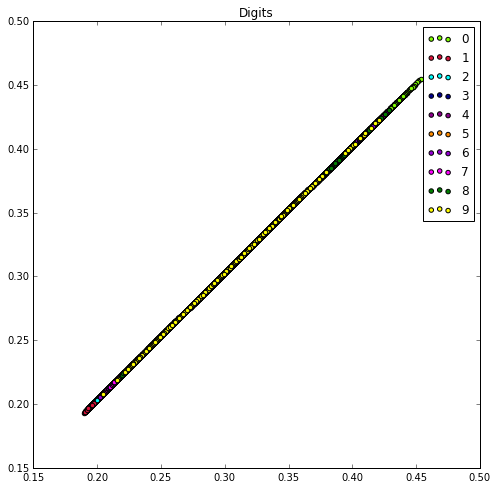

In [21]:
from sklearn.cross_validation import train_test_split
autoencoder.load_weights('./au7.chp')
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = autoencoder.transform(X_test)
print(X_transformed)
colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")


WITH DROPOUT sigmoid in enc layers and sigmoid on dec layers and L1 Regularization
-------

  0%|          | 0/100 [00:00<?, ?it/s]

autoencoder


  1%|          | 1/100 [00:10<16:47, 10.18s/it]

0 cost:  23871.9185555


  2%|▏         | 2/100 [00:20<16:34, 10.15s/it]

1 cost:  1764.33777714


  3%|▎         | 3/100 [00:30<16:24, 10.14s/it]

2 cost:  687.628325135


  4%|▍         | 4/100 [00:40<16:13, 10.14s/it]

3 cost:  519.059976727


  5%|▌         | 5/100 [00:50<16:03, 10.14s/it]

4 cost:  500.807360977


  6%|▌         | 6/100 [01:00<15:50, 10.11s/it]

5 cost:  499.226414859


  7%|▋         | 7/100 [01:10<15:41, 10.13s/it]

6 cost:  499.200400561


  8%|▊         | 8/100 [01:21<15:32, 10.14s/it]

7 cost:  499.178334475


  9%|▉         | 9/100 [01:31<15:22, 10.14s/it]

8 cost:  499.169844687


 10%|█         | 10/100 [01:41<15:06, 10.07s/it]

9 cost:  499.116494


 11%|█         | 11/100 [01:51<15:00, 10.12s/it]

10 cost:  499.164780557


 12%|█▏        | 12/100 [02:01<14:51, 10.13s/it]

11 cost:  499.078565121


 13%|█▎        | 13/100 [02:11<14:41, 10.13s/it]

12 cost:  499.09194836


 14%|█▍        | 14/100 [02:21<14:31, 10.14s/it]

13 cost:  499.056755722


 15%|█▌        | 15/100 [02:31<14:21, 10.14s/it]

14 cost:  499.044762701


 16%|█▌        | 16/100 [02:42<14:12, 10.15s/it]

15 cost:  499.012860268


 17%|█▋        | 17/100 [02:52<14:02, 10.15s/it]

16 cost:  499.007043511


 18%|█▊        | 18/100 [03:02<13:52, 10.15s/it]

17 cost:  498.98482883


 19%|█▉        | 19/100 [03:12<13:42, 10.16s/it]

18 cost:  498.97237891


 20%|██        | 20/100 [03:22<13:32, 10.16s/it]

19 cost:  498.926133841


 21%|██        | 21/100 [03:32<13:22, 10.16s/it]

20 cost:  498.937209934


 22%|██▏       | 22/100 [03:42<13:10, 10.13s/it]

21 cost:  498.908262014


 23%|██▎       | 23/100 [03:53<13:01, 10.15s/it]

22 cost:  498.887721896


 24%|██▍       | 24/100 [04:03<12:52, 10.16s/it]

23 cost:  498.890914679


 25%|██▌       | 25/100 [04:13<12:42, 10.17s/it]

24 cost:  498.876202762


 26%|██▌       | 26/100 [04:23<12:32, 10.18s/it]

25 cost:  498.841750175


 27%|██▋       | 27/100 [04:33<12:23, 10.18s/it]

26 cost:  498.868468851


 28%|██▊       | 28/100 [04:44<12:12, 10.18s/it]

27 cost:  498.820088446


 29%|██▉       | 29/100 [04:54<12:03, 10.19s/it]

28 cost:  498.826167166


 30%|███       | 30/100 [05:04<11:53, 10.19s/it]

29 cost:  498.78548643


 31%|███       | 31/100 [05:14<11:42, 10.19s/it]

30 cost:  498.812761277


 32%|███▏      | 32/100 [05:24<11:32, 10.18s/it]

31 cost:  498.830993205


 33%|███▎      | 33/100 [05:35<11:22, 10.18s/it]

32 cost:  498.743821025


 34%|███▍      | 34/100 [05:45<11:11, 10.17s/it]

33 cost:  498.788289279


 35%|███▌      | 35/100 [05:55<11:01, 10.17s/it]

34 cost:  498.760214388


 36%|███▌      | 36/100 [06:05<10:51, 10.17s/it]

35 cost:  498.735702991


 37%|███▋      | 37/100 [06:15<10:40, 10.17s/it]

36 cost:  498.77235961


 38%|███▊      | 38/100 [06:25<10:31, 10.18s/it]

37 cost:  498.745455027


 39%|███▉      | 39/100 [06:36<10:21, 10.18s/it]

38 cost:  498.718064874


 40%|████      | 40/100 [06:46<10:11, 10.19s/it]

39 cost:  498.765983611


 41%|████      | 41/100 [06:56<10:00, 10.18s/it]

40 cost:  498.707949847


 42%|████▏     | 42/100 [07:06<09:50, 10.19s/it]

41 cost:  498.714180708


 43%|████▎     | 43/100 [07:16<09:40, 10.18s/it]

42 cost:  498.664540499


 44%|████▍     | 44/100 [07:26<09:30, 10.18s/it]

43 cost:  498.679791123


 45%|████▌     | 45/100 [07:37<09:20, 10.19s/it]

44 cost:  498.645685643


 46%|████▌     | 46/100 [07:47<09:10, 10.19s/it]

45 cost:  498.678660095


 47%|████▋     | 47/100 [07:57<08:59, 10.19s/it]

46 cost:  498.586346865


 48%|████▊     | 48/100 [08:07<08:49, 10.18s/it]

47 cost:  498.653460443


 49%|████▉     | 49/100 [08:17<08:39, 10.18s/it]

48 cost:  498.614553571


 50%|█████     | 50/100 [08:28<08:29, 10.18s/it]

49 cost:  498.668965399


 51%|█████     | 51/100 [08:38<08:19, 10.18s/it]

50 cost:  498.58298099


 52%|█████▏    | 52/100 [08:48<08:08, 10.18s/it]

51 cost:  498.561399251


 53%|█████▎    | 53/100 [08:58<07:58, 10.18s/it]

52 cost:  498.566578716


 54%|█████▍    | 54/100 [09:08<07:48, 10.18s/it]

53 cost:  498.566298217


 55%|█████▌    | 55/100 [09:19<07:38, 10.18s/it]

54 cost:  498.586718261


 56%|█████▌    | 56/100 [09:29<07:28, 10.18s/it]

55 cost:  498.54624179


 57%|█████▋    | 57/100 [09:39<07:17, 10.18s/it]

56 cost:  498.561866939


 58%|█████▊    | 58/100 [09:49<07:07, 10.18s/it]

57 cost:  498.605855823


 59%|█████▉    | 59/100 [09:59<06:57, 10.18s/it]

58 cost:  498.531576782


 60%|██████    | 60/100 [10:09<06:47, 10.18s/it]

59 cost:  498.551077694


 61%|██████    | 61/100 [10:20<06:37, 10.19s/it]

60 cost:  498.519100189


 62%|██████▏   | 62/100 [10:30<06:27, 10.19s/it]

61 cost:  498.534475446


 63%|██████▎   | 63/100 [10:40<06:17, 10.19s/it]

62 cost:  498.553472668


 64%|██████▍   | 64/100 [10:50<06:06, 10.19s/it]

63 cost:  498.518285096


 65%|██████▌   | 65/100 [11:00<05:56, 10.19s/it]

64 cost:  498.534968883


 66%|██████▌   | 66/100 [11:11<05:46, 10.19s/it]

65 cost:  498.526916534


 67%|██████▋   | 67/100 [11:21<05:36, 10.19s/it]

66 cost:  498.490338445


 68%|██████▊   | 68/100 [11:31<05:25, 10.18s/it]

67 cost:  498.49722144


 69%|██████▉   | 69/100 [11:41<05:15, 10.18s/it]

68 cost:  498.480568647


 70%|███████   | 70/100 [11:51<05:05, 10.18s/it]

69 cost:  498.518692553


 71%|███████   | 71/100 [12:02<04:55, 10.19s/it]

70 cost:  498.485353976


 72%|███████▏  | 72/100 [12:12<04:45, 10.19s/it]

71 cost:  498.463151634


 73%|███████▎  | 73/100 [12:22<04:35, 10.19s/it]

72 cost:  498.47633189


 74%|███████▍  | 74/100 [12:32<04:24, 10.19s/it]

73 cost:  498.44816944


 75%|███████▌  | 75/100 [12:42<04:14, 10.19s/it]

74 cost:  498.484277159


 76%|███████▌  | 76/100 [12:52<04:04, 10.19s/it]

75 cost:  498.454921871


 77%|███████▋  | 77/100 [13:03<03:54, 10.19s/it]

76 cost:  498.476154894


 78%|███████▊  | 78/100 [13:13<03:44, 10.19s/it]

77 cost:  498.436169624


 79%|███████▉  | 79/100 [13:23<03:33, 10.19s/it]

78 cost:  498.407441199


 80%|████████  | 80/100 [13:33<03:23, 10.19s/it]

79 cost:  498.454497695


 81%|████████  | 81/100 [13:43<03:13, 10.19s/it]

80 cost:  498.400158554


 82%|████████▏ | 82/100 [13:54<03:03, 10.19s/it]

81 cost:  498.388403773


 83%|████████▎ | 83/100 [14:04<02:53, 10.20s/it]

82 cost:  498.401726991


 84%|████████▍ | 84/100 [14:14<02:43, 10.19s/it]

83 cost:  498.375170559


 85%|████████▌ | 85/100 [14:24<02:32, 10.19s/it]

84 cost:  498.435524613


 86%|████████▌ | 86/100 [14:34<02:22, 10.19s/it]

85 cost:  498.345169932


 87%|████████▋ | 87/100 [14:45<02:12, 10.19s/it]

86 cost:  498.368183851


 88%|████████▊ | 88/100 [14:55<02:02, 10.20s/it]

87 cost:  498.378518164


 89%|████████▉ | 89/100 [15:05<01:52, 10.20s/it]

88 cost:  498.301489949


 90%|█████████ | 90/100 [15:15<01:41, 10.20s/it]

89 cost:  498.35258916


 91%|█████████ | 91/100 [15:25<01:31, 10.20s/it]

90 cost:  498.363659143


 92%|█████████▏| 92/100 [15:36<01:21, 10.20s/it]

91 cost:  498.270932913


 93%|█████████▎| 93/100 [15:46<01:11, 10.20s/it]

92 cost:  498.390816331


 94%|█████████▍| 94/100 [15:56<01:01, 10.19s/it]

93 cost:  498.346672386


 95%|█████████▌| 95/100 [16:06<00:50, 10.20s/it]

94 cost:  498.357619613


 96%|█████████▌| 96/100 [16:16<00:40, 10.20s/it]

95 cost:  498.357468992


 97%|█████████▋| 97/100 [16:27<00:30, 10.21s/it]

96 cost:  498.341199011


 98%|█████████▊| 98/100 [16:37<00:20, 10.21s/it]

97 cost:  498.348294765


 99%|█████████▉| 99/100 [16:47<00:10, 10.21s/it]

98 cost:  498.321521074


100%|██████████| 100/100 [16:57<00:00, 10.22s/it]

99 cost:  498.336450785


[[ 0.49997294  0.50018334]
 [ 0.49997294  0.50018334]
 [ 0.49997294  0.50018334]
 ..., 
 [ 0.49997294  0.50018334]
 [ 0.49997294  0.50018334]
 [ 0.49997294  0.50018334]]


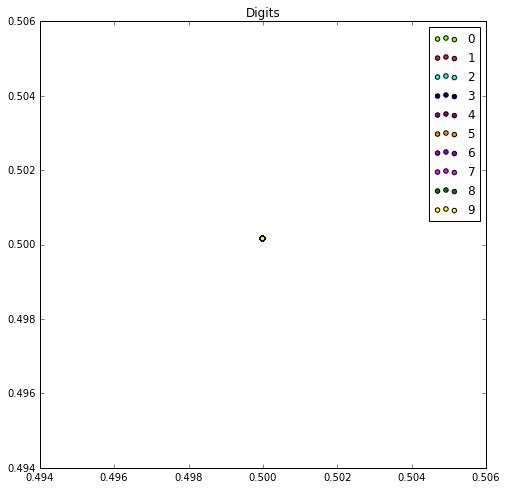

In [27]:
from au import AutoEncoder

# Train Autoencoder
batch_size =30
epoch = 100
keep_prob_value = 0.9
# Autoencoder
autoencoder = AutoEncoder(784, [1000, 500,250,2],  [['rbmw1', 'rbmhb1'],
                                                ['rbmw2', 'rbmhb2'],
                                                ['rbmw3', 'rbmhb3'],
                                                   ['rbmw4', 'rbmhb4']],
                                           tied_weights=False,keep_prob=keep_prob_value,regtype='l1',
                                          transfer_function_enc=tf.nn.sigmoid,
                                          transfer_function_dec=tf.nn.sigmoid)
# Load RBM weights to Autoencoder
autoencoder.load_rbm_weights('./rbmw1.chp', ['rbmw1', 'rbmhb1'], 0)
autoencoder.load_rbm_weights('./rbmw2.chp', ['rbmw2', 'rbmhb2'], 1)
autoencoder.load_rbm_weights('./rbmw3.chp', ['rbmw3', 'rbmhb3'], 2)
autoencoder.load_rbm_weights('./rbmw4.chp', ['rbmw4', 'rbmhb4'], 3)

interactions = int(math.floor(images.shape[0]/batch_size))
print('autoencoder')
for i in tqdm(range(epoch)):
    cost = 0.0
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        cost += autoencoder.partial_fit(batch_xs)
    print(i,'cost: ',cost)

autoencoder.save_weights('./au8.chp')


[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 ..., 
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


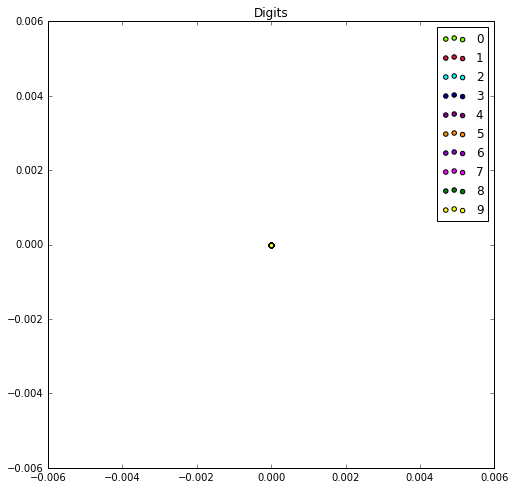

In [30]:
from sklearn.cross_validation import train_test_split
autoencoder.load_weights('./au8.chp')
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = autoencoder.transform(X_test)
print(X_transformed)
colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")


WITHOUT DROPOUT relu in enc layers and sigmoid on dec layers and L1 Regularization
-------

  0%|          | 0/100 [00:00<?, ?it/s]

autoencoder


  1%|          | 1/100 [00:10<17:10, 10.41s/it]

0 cost:  23961.9606571


  2%|▏         | 2/100 [00:20<16:56, 10.38s/it]

1 cost:  1780.82359135


  3%|▎         | 3/100 [00:31<16:44, 10.35s/it]

2 cost:  676.723287433


  4%|▍         | 4/100 [00:41<16:31, 10.33s/it]

3 cost:  493.074634045


  5%|▌         | 5/100 [00:51<16:20, 10.32s/it]

4 cost:  462.70645225


  6%|▌         | 6/100 [01:01<16:11, 10.33s/it]

5 cost:  452.194962084


  7%|▋         | 7/100 [01:12<16:00, 10.33s/it]

6 cost:  446.038753897


  8%|▊         | 8/100 [01:22<15:50, 10.33s/it]

7 cost:  441.512812674


  9%|▉         | 9/100 [01:32<15:39, 10.33s/it]

8 cost:  438.920550764


 10%|█         | 10/100 [01:43<15:29, 10.32s/it]

9 cost:  437.835242063


 11%|█         | 11/100 [01:53<15:18, 10.32s/it]

10 cost:  436.689278126


 12%|█▏        | 12/100 [02:03<15:08, 10.32s/it]

11 cost:  436.174344242


 13%|█▎        | 13/100 [02:14<14:58, 10.33s/it]

12 cost:  435.679668784


 14%|█▍        | 14/100 [02:24<14:48, 10.33s/it]

13 cost:  435.441754997


 15%|█▌        | 15/100 [02:34<14:38, 10.33s/it]

14 cost:  435.110713124


 16%|█▌        | 16/100 [02:45<14:27, 10.33s/it]

15 cost:  434.734195799


 17%|█▋        | 17/100 [02:55<14:17, 10.34s/it]

16 cost:  434.42934972


 18%|█▊        | 18/100 [03:05<14:07, 10.34s/it]

17 cost:  434.636774391


 19%|█▉        | 19/100 [03:16<13:57, 10.34s/it]

18 cost:  434.075040787


 20%|██        | 20/100 [03:26<13:46, 10.33s/it]

19 cost:  433.950063974


 21%|██        | 21/100 [03:36<13:36, 10.33s/it]

20 cost:  433.704970956


 22%|██▏       | 22/100 [03:47<13:25, 10.33s/it]

21 cost:  433.258330196


 23%|██▎       | 23/100 [03:57<13:15, 10.33s/it]

22 cost:  433.170850277


 24%|██▍       | 24/100 [04:07<13:04, 10.33s/it]

23 cost:  433.325054824


 25%|██▌       | 25/100 [04:18<12:54, 10.32s/it]

24 cost:  433.085048825


 26%|██▌       | 26/100 [04:28<12:43, 10.32s/it]

25 cost:  432.956473351


 27%|██▋       | 27/100 [04:38<12:34, 10.33s/it]

26 cost:  433.406322509


 28%|██▊       | 28/100 [04:49<12:23, 10.33s/it]

27 cost:  432.711260438


 29%|██▉       | 29/100 [04:59<12:13, 10.33s/it]

28 cost:  432.91376406


 30%|███       | 30/100 [05:09<12:03, 10.33s/it]

29 cost:  432.702157438


 31%|███       | 31/100 [05:20<11:53, 10.34s/it]

30 cost:  433.021342874


 32%|███▏      | 32/100 [05:30<11:42, 10.34s/it]

31 cost:  431.983535498


 33%|███▎      | 33/100 [05:40<11:32, 10.33s/it]

32 cost:  432.365137219


 34%|███▍      | 34/100 [05:51<11:21, 10.33s/it]

33 cost:  432.65155375


 35%|███▌      | 35/100 [06:01<11:11, 10.33s/it]

34 cost:  432.098711491


 36%|███▌      | 36/100 [06:11<11:01, 10.33s/it]

35 cost:  432.007792383


 37%|███▋      | 37/100 [06:22<10:50, 10.33s/it]

36 cost:  432.47447902


 38%|███▊      | 38/100 [06:32<10:40, 10.33s/it]

37 cost:  431.564667225


 39%|███▉      | 39/100 [06:42<10:30, 10.33s/it]

38 cost:  431.621378064


 40%|████      | 40/100 [06:53<10:19, 10.33s/it]

39 cost:  432.54700169


 41%|████      | 41/100 [07:03<10:09, 10.33s/it]

40 cost:  431.641129255


 42%|████▏     | 42/100 [07:13<09:58, 10.33s/it]

41 cost:  431.621618122


 43%|████▎     | 43/100 [07:24<09:48, 10.33s/it]

42 cost:  431.666974664


 44%|████▍     | 44/100 [07:34<09:38, 10.33s/it]

43 cost:  431.455765545


 45%|████▌     | 45/100 [07:44<09:27, 10.32s/it]

44 cost:  430.904856503


 46%|████▌     | 46/100 [07:55<09:17, 10.32s/it]

45 cost:  431.501178354


 47%|████▋     | 47/100 [08:05<09:06, 10.31s/it]

46 cost:  430.998618007


 48%|████▊     | 48/100 [08:15<08:56, 10.32s/it]

47 cost:  430.863048106


 49%|████▉     | 49/100 [08:26<08:46, 10.32s/it]

48 cost:  431.064661115


 50%|█████     | 50/100 [08:36<08:35, 10.32s/it]

49 cost:  432.43576172


 51%|█████     | 51/100 [08:46<08:25, 10.32s/it]

50 cost:  430.900230676


 52%|█████▏    | 52/100 [08:56<08:15, 10.32s/it]

51 cost:  431.598697096


 53%|█████▎    | 53/100 [09:07<08:05, 10.32s/it]

52 cost:  430.941440046


 54%|█████▍    | 54/100 [09:17<07:54, 10.33s/it]

53 cost:  431.127718449


 55%|█████▌    | 55/100 [09:27<07:44, 10.32s/it]

54 cost:  431.621440887


 56%|█████▌    | 56/100 [09:38<07:34, 10.32s/it]

55 cost:  431.57431218


 57%|█████▋    | 57/100 [09:48<07:23, 10.32s/it]

56 cost:  431.322260946


 58%|█████▊    | 58/100 [09:58<07:13, 10.32s/it]

57 cost:  431.233713955


 59%|█████▉    | 59/100 [10:09<07:03, 10.32s/it]

58 cost:  430.508577019


 60%|██████    | 60/100 [10:19<06:52, 10.32s/it]

59 cost:  431.040820986


 61%|██████    | 61/100 [10:29<06:42, 10.32s/it]

60 cost:  430.532908022


 62%|██████▏   | 62/100 [10:40<06:32, 10.32s/it]

61 cost:  430.290655017


 63%|██████▎   | 63/100 [10:50<06:21, 10.32s/it]

62 cost:  430.006488055


 64%|██████▍   | 64/100 [11:00<06:11, 10.32s/it]

63 cost:  428.867769629


 65%|██████▌   | 65/100 [11:11<06:01, 10.33s/it]

64 cost:  429.784809947


 66%|██████▌   | 66/100 [11:21<05:50, 10.32s/it]

65 cost:  429.287877291


 67%|██████▋   | 67/100 [11:31<05:40, 10.33s/it]

66 cost:  430.656369388


 68%|██████▊   | 68/100 [11:42<05:30, 10.33s/it]

67 cost:  430.562369525


 69%|██████▉   | 69/100 [11:52<05:20, 10.33s/it]

68 cost:  430.004808873


 70%|███████   | 70/100 [12:02<05:09, 10.33s/it]

69 cost:  429.670767248


 71%|███████   | 71/100 [12:13<04:59, 10.32s/it]

70 cost:  429.682733804


 72%|███████▏  | 72/100 [12:23<04:49, 10.33s/it]

71 cost:  427.875982672


 73%|███████▎  | 73/100 [12:33<04:38, 10.33s/it]

72 cost:  429.722657233


 74%|███████▍  | 74/100 [12:44<04:28, 10.34s/it]

73 cost:  429.00821048


 75%|███████▌  | 75/100 [12:54<04:18, 10.34s/it]

74 cost:  428.867370337


 76%|███████▌  | 76/100 [13:04<04:07, 10.33s/it]

75 cost:  428.908874542


 77%|███████▋  | 77/100 [13:15<03:57, 10.33s/it]

76 cost:  427.58422491


 78%|███████▊  | 78/100 [13:25<03:47, 10.33s/it]

77 cost:  427.180664629


 79%|███████▉  | 79/100 [13:35<03:36, 10.33s/it]

78 cost:  428.321284294


 80%|████████  | 80/100 [13:46<03:26, 10.33s/it]

79 cost:  428.160594225


 81%|████████  | 81/100 [13:56<03:16, 10.33s/it]

80 cost:  426.815635651


 82%|████████▏ | 82/100 [14:06<03:06, 10.34s/it]

81 cost:  427.290670395


 83%|████████▎ | 83/100 [14:17<02:55, 10.34s/it]

82 cost:  426.685407877


 84%|████████▍ | 84/100 [14:27<02:45, 10.34s/it]

83 cost:  427.268470228


 85%|████████▌ | 85/100 [14:37<02:35, 10.34s/it]

84 cost:  427.504348576


 86%|████████▌ | 86/100 [14:48<02:24, 10.34s/it]

85 cost:  428.012139529


 87%|████████▋ | 87/100 [14:58<02:14, 10.34s/it]

86 cost:  427.610769302


 88%|████████▊ | 88/100 [15:08<02:04, 10.34s/it]

87 cost:  427.992111325


 89%|████████▉ | 89/100 [15:19<01:53, 10.34s/it]

88 cost:  427.529669225


 90%|█████████ | 90/100 [15:29<01:43, 10.32s/it]

89 cost:  427.110397816


 91%|█████████ | 91/100 [15:39<01:31, 10.17s/it]

90 cost:  426.652864218


 92%|█████████▏| 92/100 [15:49<01:20, 10.02s/it]

91 cost:  425.999893606


 93%|█████████▎| 93/100 [15:59<01:10, 10.02s/it]

92 cost:  428.014768451


 94%|█████████▍| 94/100 [16:08<00:59,  9.99s/it]

93 cost:  425.82094872


 95%|█████████▌| 95/100 [16:19<00:50, 10.03s/it]

94 cost:  425.390632123


 96%|█████████▌| 96/100 [16:28<00:39, 10.00s/it]

95 cost:  425.933965921


 97%|█████████▋| 97/100 [16:39<00:30, 10.10s/it]

96 cost:  425.976932049


 98%|█████████▊| 98/100 [16:49<00:20, 10.17s/it]

97 cost:  425.845802039


 99%|█████████▉| 99/100 [16:59<00:10, 10.21s/it]

98 cost:  426.317867368


100%|██████████| 100/100 [17:10<00:00, 10.25s/it]

99 cost:  425.838983655


[[ 0.11961844  0.05259935]
 [ 0.12323404  0.03755473]
 [ 0.02315345  0.03631484]
 ..., 
 [ 0.12435079  0.0461577 ]
 [ 0.12371558  0.12707499]
 [ 0.11229382  0.19739503]]


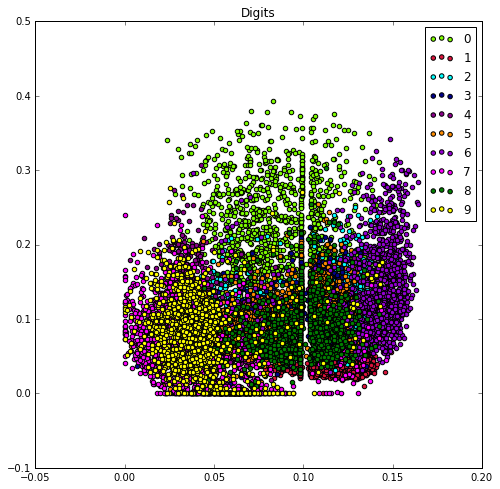

In [28]:
from au import AutoEncoder

# Train Autoencoder
batch_size =30
epoch = 100
keep_prob_value = 1
# Autoencoder
autoencoder = AutoEncoder(784, [1000, 500,250,2],  [['rbmw1', 'rbmhb1'],
                                                ['rbmw2', 'rbmhb2'],
                                                ['rbmw3', 'rbmhb3'],
                                                   ['rbmw4', 'rbmhb4']],
                                           tied_weights=False,keep_prob=keep_prob_value,regtype='l1')
# Load RBM weights to Autoencoder
autoencoder.load_rbm_weights('./rbmw1.chp', ['rbmw1', 'rbmhb1'], 0)
autoencoder.load_rbm_weights('./rbmw2.chp', ['rbmw2', 'rbmhb2'], 1)
autoencoder.load_rbm_weights('./rbmw3.chp', ['rbmw3', 'rbmhb3'], 2)
autoencoder.load_rbm_weights('./rbmw4.chp', ['rbmw4', 'rbmhb4'], 3)

interactions = int(math.floor(images.shape[0]/batch_size))
print('autoencoder')
for i in tqdm(range(epoch)):
    cost = 0.0
    for j in range(interactions):
        batch_xs, batch_ys = next_batch(j*batch_size, images,labels,batch_size)
        cost += autoencoder.partial_fit(batch_xs)
    print(i,'cost: ',cost)

autoencoder.save_weights('./au9.chp')



[[ 0.11961844  0.05259935]
 [ 0.12323404  0.03755473]
 [ 0.02315345  0.03631484]
 ..., 
 [ 0.12435079  0.0461577 ]
 [ 0.12371558  0.12707499]
 [ 0.11229382  0.19739503]]


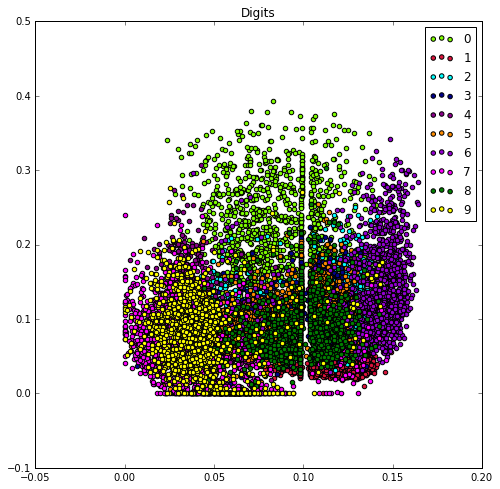

In [31]:
from sklearn.cross_validation import train_test_split
autoencoder.load_weights('./au9.chp')
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
X_transformed = autoencoder.transform(X_test)
print(X_transformed)
colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")

PCA
-----

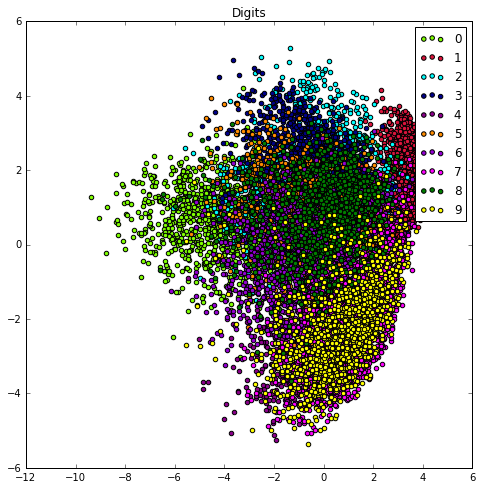

In [29]:
from sklearn.decomposition import PCA
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)
pca = PCA(n_components=3).fit(X_train)
X_transformed = pca.transform(X_test)

colors= ["chartreuse","crimson","cyan","darkblue","darkmagenta","darkorange","darkviolet","fuchsia","green","yellow"]
plt.figure(figsize=(8, 8))
for c, i,target_name in zip(colors, range(10),map(lambda x:str(x),range(10))):
    plt.scatter(X_transformed[y_test == i, 0], X_transformed[y_test == i, 1],
                c=c, label=target_name)
    plt.title("Digits")
plt.legend(loc="best")
